# **NLP modelling using Google Colab**

# 1 - IMPORTS

## 1.1 - Libraries

*Load required libraries for the project*

In [1]:
!pip install --upgrade -q pylangacq catboost shap

In [2]:
# OS
import os
from   pathlib import Path

# import required libraries
from google.colab import files

# date
from datetime import datetime

# data manipulation
import re
import numpy      as     np
import pandas     as     pd

# plot and images
import seaborn              as sns
import matplotlib.pyplot    as plt

# NLP 
import pylangacq

# Generating Synthetic data
from imblearn.over_sampling  import RandomOverSampler, SMOTE, ADASYN, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks

# modelling
from sklearn.model_selection   import train_test_split, LeavePOut, StratifiedKFold, learning_curve, cross_validate, RepeatedStratifiedKFold
from sklearn.preprocessing     import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics           import log_loss, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, log_loss, make_scorer, plot_confusion_matrix
from sklearn.inspection        import permutation_importance
from sklearn.feature_selection import mutual_info_classif
from sklearn.dummy             import DummyClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.svm               import SVC
from sklearn.naive_bayes       import BernoulliNB, ComplementNB
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.ensemble          import RandomForestClassifier
from lightgbm                  import LGBMClassifier
from catboost                  import CatBoostClassifier

# explainability
import shap

## 1.2 - Functions

*Define functions that will be used on the project*

In [3]:
# TO-DO

## 1.3 - Setup

*Set some configurations for the whole project*

In [4]:
# set cientific notation for pandas
pd.set_option(
    "display.float_format", "{:,.3f}".format 
)

# don't truncate columns
pd.set_option("display.max_colwidth", 100)  # None for unlimited
# display all columns
pd.set_option("display.max_columns", None)

# plot style
plt.style.use('fivethirtyeight')

## 1.4 - Constants 

*Define constants that will be used throughout the project*

In [5]:
# define seed and random states
seed = 0

# 2 - DATA EXTRACTION

## 2.1 - Data dictionary

*Describe the meaning of every column of the dataset*

In [6]:
# TO-DO

## 2.2 - Data Loading

*Load data from required files*

In [7]:
# # upload data
# uploaded = files.upload()

In [8]:
# list files in colab folder
print(os.listdir("."))

['.config', 'Nadig.zip', 'sample_data']


In [9]:
def extract_features(pylangacq_zip_path, chi_part_tag, non_child_part_list=None):
    """
    Extract features from .cha files in pylangacq_zip_path.zip file using pylangacq library

    Args
        pylangacq_zip_path: a string with the file path to a .zip with .cha files inside of it
        chi_part_tag: a string with the tag of child on .cha files
        non_child_part_list: a list of string with non-child participants to extract features

    Return
        df_extraction: a pandas dataframe with features extracted per .cha files
    """

    ###################
    # validate inputs #
    ###################
    # pylangacq_zip_path param
    if not os.path.exists(pylangacq_zip_path):
        # raise error
        raise ValueError("pylangacq_zip_path file doesn't exist.")
    # chi_part_tag param
    if not isinstance(chi_part_tag, str):
        # raise error
        raise TypeError("'chi_part_tag' param must be a string")
    # check if non_child_part_list was input
    if not non_child_part_list is None:
        # validate inputs
        if not isinstance(non_child_part_list, list):
            # raise error
            raise TypeError("'non_child_part_list' param must be a list")

    ##################
    # Read .zip file # 
    ##################

    # extract info from .zip file
    pylang_data = pylangacq.read_chat( pylangacq_zip_path )

    # print number of transcriptions
    print(
        f"\n{'*'*49}\n"
        f"Extracting features from {pylang_data.n_files()} transcriptions"
        f"\n{'*'*49}\n"
    )

    # create an empty dataframe 
    df_extraction = pd.DataFrame()

    #########################################
    # EXtract features from each .cha files #
    #########################################

    # iterate over transcripts
    for idx, nadig_i in enumerate(pylang_data):
        # create a dictionary for extracted features
        features_dict = {}
        
        ####### add values to dataframe #######
        # add ASD label
        features_dict["ASD"] = nadig_i.headers()[0]["Participants"][chi_part_tag]["group"]
        
        # check if non_child_part_tags was input
        if not non_child_part_list is None:
            # define non_child_part_tags
            non_child_part_tags = non_child_part_list.copy()

        # no non_child_part_tags was input
        else:
            # get non-child participants tags
            non_child_part_tags = list(nadig_i.headers()[0]["Participants"].keys())
            # remove child tag
            non_child_part_tags.remove(chi_part_tag)

        # print report
        print(
            f'File {pylang_data.file_paths()[idx]} has the following participants: {list(nadig_i.headers()[0]["Participants"].keys())}\n'
            f'\tSelected child participant tag to calculate features:      {chi_part_tag}\n'
            f'\tSelected non-child participant tags to calculate features: {", ".join(non_child_part_tags)}.'
        )

        # get mlu
        child_mlu = nadig_i.mlu(participant=chi_part_tag)[0]    
        # get mean mlu for non-child participants
        mean_mlu_non_child = np.mean([nadig_i.mlu(participant=non_child)[0] 
                                    for non_child 
                                    in non_child_part_tags])
        # check misleading information
        if mean_mlu_non_child == 0:
            # print report
            print(f'-------> File {pylang_data.file_paths()[idx]} has mean_mlu_non_child = zero. Does this make sense? <-------')
        # avoid error by zero division    
        mean_mlu_non_child = (mean_mlu_non_child if mean_mlu_non_child != 0 else 0.1)
        # add child mlu
        features_dict["child_mlu"] = child_mlu
        # get percentage of child mlu / non-child mean mlu
        features_dict["percent_child_parents_mlu"] = child_mlu / mean_mlu_non_child

        # get mluw
        child_mluw = nadig_i.mluw(participant=chi_part_tag)[0]
        # get mean mluw for non-child participants
        mean_mluw_non_child = np.mean([nadig_i.mluw(participant=non_child)[0] 
                                    for non_child 
                                    in non_child_part_tags])
        # check misleading information
        if mean_mluw_non_child == 0:
            # print report
            print(f'-------> File {pylang_data.file_paths()[idx]} has mean_mluw_non_child = zero. Does this make sense? <-------')
        # avoid error by zero division    
        mean_mluw_non_child = (mean_mluw_non_child if mean_mluw_non_child != 0 else 0.1)
        # add child mluw
        features_dict["child_mluw"] = child_mluw
        # get percentage of child mluw / non-child mean mluw
        features_dict["percent_child_parents_mluw"] = child_mluw / mean_mluw_non_child

        # get ttr
        child_ttr = nadig_i.ttr(participant=chi_part_tag)[0]
        # get mean ttr for non-child participants
        mean_ttr_non_child = np.mean([nadig_i.ttr(participant=non_child)[0] 
                                    for non_child 
                                    in non_child_part_tags])
        # check misleading information
        if mean_ttr_non_child == 0:
            # print report
            print(f'-------> File {pylang_data.file_paths()[idx]} has mean_ttr_non_child = zero. Does this make sense? <-------')
        # avoid error by zero division    
        mean_ttr_non_child = (mean_ttr_non_child if mean_ttr_non_child != 0 else 0.1)
        # add child ttr
        features_dict["child_ttr"] = child_ttr
        # get percentage of child ttr / non-child mean ttr
        features_dict["percent_child_parents_ttr"] = child_ttr / mean_ttr_non_child

        # get ipsyn
        child_ipsyn = nadig_i.ipsyn(participant=chi_part_tag)[0]
        # get mean ipsyn for non-child participants
        mean_ipsyn_non_child = np.mean([nadig_i.ipsyn(participant=non_child)[0] 
                                        for non_child 
                                        in non_child_part_tags])
        # check misleading information
        if mean_ipsyn_non_child == 0:
            # print report
            print(f'-------> File {pylang_data.file_paths()[idx]} has mean_ipsyn_non_child = zero. Does this make sense? <-------')
        # avoid error by zero division    
        mean_ipsyn_non_child = (mean_ipsyn_non_child if mean_ipsyn_non_child != 0 else 0.1)
        # add child ipsyn
        features_dict["child_ipsyn"] = child_ipsyn
        # get percentage of child ipsyn / non-child mean ipsyn
        features_dict["percent_child_parents_ipsyn"] = child_ipsyn / mean_ipsyn_non_child

        # get number of words
        features_dict["child_num_words"] = len(nadig_i.words(participants=chi_part_tag))
        # get percentage of child words / parent words
        features_dict["perct_child_parents_words"] = len(nadig_i.words(participants=chi_part_tag)) / len(nadig_i.words(exclude=(chi_part_tag)))
        # get number of unique words
        features_dict["child_num_unique_words"] = len(set(nadig_i.words(participants=chi_part_tag)))
        # get percentage of child unique words / parent unique words
        features_dict["perct_child_parents_unique_words"] = len(set(nadig_i.words(participants=chi_part_tag))) / len(set(nadig_i.words(exclude=(chi_part_tag))))
        # get number of tokens
        features_dict["child_num_tokens"] = len(nadig_i.tokens(participants=chi_part_tag))
        # get percentage of child tokens / parent tokens
        features_dict["perct_child_parents_tokens"] = len(nadig_i.tokens(participants=chi_part_tag)) / len(nadig_i.tokens(exclude=(chi_part_tag)))
        # get number of utterances
        features_dict["child_utterances"] = len(nadig_i.utterances(participants=chi_part_tag))
        # get percentage of child utterances / parent utterances
        features_dict["perct_child_parents_utterances"] = len(nadig_i.utterances(participants=chi_part_tag)) / len(nadig_i.utterances(exclude=chi_part_tag))

        # get part of speech (POS) for every token in child utterances
        child_pos = [token.pos for token in nadig_i.tokens(participants=chi_part_tag)]   
        # get number of tokens
        num_tokens = features_dict["child_num_tokens"]
        # sanity check
        assert num_tokens == len(child_pos), "Missing POS tags!"
        
        # get values counts for pos
        pos_value_counts = pd.Series(child_pos).value_counts(dropna=False)
        # convert to dict
        pos_value_counts_dict = pos_value_counts.to_dict()
        # add pos_ prefix before pos tags
        pos_value_counts_dict = { ("pos_percent_" + str(k)): (v / num_tokens) for k, v in pos_value_counts_dict.items() }
        # sanity check 
        assert abs(1 - sum([*pos_value_counts_dict.values()])) < 0.01, "Missing POS tags!"
        
        # add pos_value_counts_dict to features_dict
        features_dict = {**features_dict, **pos_value_counts_dict}
        # create a pandas dataframe from features dict
        df_features = pd.DataFrame(data=features_dict, index=[0])
        # concatenate features dataframe with extraction dataframe
        df_extraction = pd.concat(objs=[df_extraction, df_features], ignore_index=True)

    # print report
    print(
        f"\n{'*'*49}\n"        
        f"{df_extraction.shape[1]-1} features extracted from {df_extraction.shape[0]}"
        f"\n{'*'*49}\n"
    )

    return df_extraction

In [10]:
# extract features
df_nadig = extract_features( "Nadig.zip", chi_part_tag="CHI", non_child_part_list=None )
# df_eigsti = extract_features( "Eigsti.zip", chi_part_tag="CHI", non_child_part_list=None )
# df_quigley = extract_features( "QuigleyMcNally.zip", chi_part_tag="CHI", non_child_part_list=None )

# concatenate dataframes
# df_extraction = pd.concat(objs=[df_nadig, df_eigsti], ignore_index=True)
# df_extraction = df_eigsti.copy()
df_extraction = df_nadig.copy()

# inspect dataframe
display(df_extraction.columns.tolist(), df_extraction.sample(7))


*************************************************
Extracting features from 38 transcriptions
*************************************************

File Nadig/101.cha has the following participants: ['CHI', 'MOT']
	Selected child participant tag to calculate features:      CHI
	Selected non-child participant tags to calculate features: MOT.
File Nadig/102.cha has the following participants: ['CHI', 'MOT']
	Selected child participant tag to calculate features:      CHI
	Selected non-child participant tags to calculate features: MOT.
File Nadig/103.cha has the following participants: ['CHI', 'MOT']
	Selected child participant tag to calculate features:      CHI
	Selected non-child participant tags to calculate features: MOT.
File Nadig/104.cha has the following participants: ['CHI', 'MOT']
	Selected child participant tag to calculate features:      CHI
	Selected non-child participant tags to calculate features: MOT.
File Nadig/108.cha has the following participants: ['CHI', 'MOT']
	Selected

['ASD',
 'child_mlu',
 'percent_child_parents_mlu',
 'child_mluw',
 'percent_child_parents_mluw',
 'child_ttr',
 'percent_child_parents_ttr',
 'child_ipsyn',
 'percent_child_parents_ipsyn',
 'child_num_words',
 'perct_child_parents_words',
 'child_num_unique_words',
 'perct_child_parents_unique_words',
 'child_num_tokens',
 'perct_child_parents_tokens',
 'child_utterances',
 'perct_child_parents_utterances',
 'pos_percent_co',
 'pos_percent_.',
 'pos_percent_nan',
 'pos_percent_n',
 'pos_percent_v',
 'pos_percent_!',
 'pos_percent_pro:sub',
 'pos_percent_adv',
 'pos_percent_neg',
 'pos_percent_qn',
 'pos_percent_?',
 'pos_percent_prep',
 'pos_percent_mod',
 'pos_percent_pro:per',
 'pos_percent_pro:dem',
 'pos_percent_adj',
 'pos_percent_pro:rel',
 'pos_percent_det:art',
 'pos_percent_pro:int',
 'pos_percent_aux',
 'pos_percent_cop',
 'pos_percent_+...',
 'pos_percent_inf',
 'pos_percent_conj',
 'pos_percent_coord',
 'pos_percent_+!?',
 'pos_percent_post',
 'pos_percent_pro:indef',
 'po

,ASD,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,perct_child_parents_words,child_num_unique_words,perct_child_parents_unique_words,child_num_tokens,perct_child_parents_tokens,child_utterances,perct_child_parents_utterances,pos_percent_co,pos_percent_.,pos_percent_nan,pos_percent_n,pos_percent_v,pos_percent_!,pos_percent_pro:sub,pos_percent_adv,pos_percent_neg,pos_percent_qn,pos_percent_?,pos_percent_prep,pos_percent_mod,pos_percent_pro:per,pos_percent_pro:dem,pos_percent_adj,pos_percent_pro:rel,pos_percent_det:art,pos_percent_pro:int,pos_percent_aux,pos_percent_cop,pos_percent_+...,pos_percent_inf,pos_percent_conj,pos_percent_coord,pos_percent_+!?,pos_percent_post,pos_percent_pro:indef,pos_percent_part,pos_percent_det:poss,pos_percent_pro:obj,pos_percent_cm,pos_percent_det:num,pos_percent_adv:tem,pos_percent_+/.,pos_percent_det:dem,pos_percent_pro:exist,pos_percent_comp,pos_percent_n:prop,pos_percent_mid#n,pos_percent_on,pos_percent_re#v,pos_percent_n:gerund,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
17,ASD,1.389,0.317,1.125,0.320,0.254,1.144,15,0.197,158,0.152,18,0.103,158,0.148,95,0.417,0.253,0.184,0.247,0.044,0.006,0.171,0.006,0.013,NaN,NaN,NaN,NaN,NaN,0.006,NaN,0.013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,TYP,1.581,0.361,1.359,0.396,0.358,1.278,18,0.243,126,0.209,22,0.165,131,0.202,74,0.532,0.229,0.183,0.267,0.023,0.008,0.069,NaN,NaN,NaN,0.015,0.038,NaN,NaN,0.031,0.015,NaN,NaN,0.031,0.008,NaN,0.038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031,NaN,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008,NaN,NaN,NaN
31,TYP,2.640,0.558,2.060,0.549,0.274,0.910,44,0.629,380,0.483,70,0.374,383,0.455,139,0.808,0.157,0.256,0.057,0.044,0.084,0.029,0.023,0.065,NaN,0.010,0.018,0.010,0.016,0.065,0.003,0.003,NaN,0.021,0.003,NaN,0.005,0.003,0.013,NaN,0.003,NaN,NaN,0.008,0.003,0.003,0.005,0.003,0.050,0.003,NaN,NaN,NaN,NaN,0.039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ASD,5.213,0.841,4.023,0.832,0.421,0.972,81,0.931,462,0.918,153,0.845,486,0.907,94,1.093,0.076,0.156,0.012,0.113,0.103,0.016,0.051,0.051,0.004,0.016,0.006,0.035,0.029,0.031,0.016,0.021,NaN,0.074,0.010,0.006,0.041,0.002,0.029,0.010,0.006,NaN,0.002,0.004,0.010,0.004,0.008,0.031,0.002,NaN,NaN,0.008,0.004,0.002,0.002,0.002,0.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,TYP,1.051,0.218,1.000,0.255,1.000,4.445,3,0.043,41,0.043,4,0.024,41,0.041,39,0.203,NaN,0.049,0.902,0.024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024,NaN
30,TYP,1.952,0.341,1.382,0.302,0.438,1.827,42,0.494,210,0.156,49,0.187,214,0.149,105,0.438,0.196,0.299,0.136,0.084,0.005,0.023,NaN,0.037,0.005,0.005,0.033,0.014,NaN,0.005,0.009,NaN,NaN,0.019,0.005,0.005,0.023,NaN,NaN,NaN,NaN,NaN,0.005,0.005,NaN,NaN,NaN,NaN,0.009,NaN,NaN,NaN,0.014,NaN,0.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042,NaN,NaN,NaN,NaN,NaN
11,ASD,2.568,0.651,1.816,0.626,0.435,1.465,20,0.328,115,0.221,33,0.287,115,0.207,44,0.341,0.130,0.313,0.052,0.139,0.017,0.017,NaN,0.009,NaN,NaN,NaN,NaN,NaN,0.009,NaN,0.017,NaN,0.009,NaN,NaN,0.009,NaN,NaN,NaN,NaN,NaN,NaN,0.009,NaN,NaN,NaN,0.017,0.217,NaN,NaN,NaN,NaN,NaN,0.009,NaN,0.017,NaN,NaN,NaN,NaN,NaN,NaN,0.009,NaN,NaN,NaN,NaN,NaN


In [11]:
# print report
print(df_extraction["ASD"].unique())

# remove DD children
# df_extraction = df_extraction[df_extraction["ASD"] != "DD"]

# print report
print(df_extraction["ASD"].unique())

['TYP' 'ASD']
['TYP' 'ASD']


# 3 - DATA DESCRIPTION

## 3.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [12]:
# create a restore point for the previous section dataframe
df_description = df_extraction.copy()

# check dataframe
df_description.sample(3)

,ASD,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,perct_child_parents_words,child_num_unique_words,perct_child_parents_unique_words,child_num_tokens,perct_child_parents_tokens,child_utterances,perct_child_parents_utterances,pos_percent_co,pos_percent_.,pos_percent_nan,pos_percent_n,pos_percent_v,pos_percent_!,pos_percent_pro:sub,pos_percent_adv,pos_percent_neg,pos_percent_qn,pos_percent_?,pos_percent_prep,pos_percent_mod,pos_percent_pro:per,pos_percent_pro:dem,pos_percent_adj,pos_percent_pro:rel,pos_percent_det:art,pos_percent_pro:int,pos_percent_aux,pos_percent_cop,pos_percent_+...,pos_percent_inf,pos_percent_conj,pos_percent_coord,pos_percent_+!?,pos_percent_post,pos_percent_pro:indef,pos_percent_part,pos_percent_det:poss,pos_percent_pro:obj,pos_percent_cm,pos_percent_det:num,pos_percent_adv:tem,pos_percent_+/.,pos_percent_det:dem,pos_percent_pro:exist,pos_percent_comp,pos_percent_n:prop,pos_percent_mid#n,pos_percent_on,pos_percent_re#v,pos_percent_n:gerund,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
15,ASD,2.483,0.510,2.275,0.615,0.552,1.987,55,0.671,203,0.223,67,0.335,215,0.217,87,0.442,0.065,0.209,0.167,0.088,0.065,0.023,0.074,0.019,0.014,0.005,0.005,0.023,0.028,0.028,0.014,0.009,NaN,0.042,NaN,0.009,0.023,NaN,0.009,NaN,NaN,NaN,NaN,NaN,0.028,0.005,0.009,NaN,NaN,NaN,NaN,0.005,NaN,NaN,0.019,NaN,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005,NaN,NaN,NaN,NaN
26,ASD,1.000,0.198,0.000,0.000,0.000,0.000,0,0.000,3,0.012,1,0.013,3,0.011,3,0.059,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,TYP,4.084,0.860,3.129,0.834,0.364,1.052,69,0.802,497,0.588,136,0.589,515,0.579,131,0.716,0.089,0.212,0.029,0.091,0.107,0.004,0.052,0.064,0.016,0.008,0.008,0.023,0.027,0.033,0.006,0.033,NaN,0.025,NaN,0.016,0.016,NaN,0.017,0.004,0.010,NaN,0.004,0.006,0.023,0.025,0.014,0.008,NaN,0.002,0.002,0.004,NaN,NaN,0.012,NaN,0.002,NaN,NaN,NaN,0.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008


## 3.2 - Column Names

*Search for misleading or error-prone column names*

In [13]:
# check column names
df_description.columns

Index(['ASD', 'child_mlu', 'percent_child_parents_mlu', 'child_mluw',
       'percent_child_parents_mluw', 'child_ttr', 'percent_child_parents_ttr',
       'child_ipsyn', 'percent_child_parents_ipsyn', 'child_num_words',
       'perct_child_parents_words', 'child_num_unique_words',
       'perct_child_parents_unique_words', 'child_num_tokens',
       'perct_child_parents_tokens', 'child_utterances',
       'perct_child_parents_utterances', 'pos_percent_co', 'pos_percent_.',
       'pos_percent_nan', 'pos_percent_n', 'pos_percent_v', 'pos_percent_!',
       'pos_percent_pro:sub', 'pos_percent_adv', 'pos_percent_neg',
       'pos_percent_qn', 'pos_percent_?', 'pos_percent_prep',
       'pos_percent_mod', 'pos_percent_pro:per', 'pos_percent_pro:dem',
       'pos_percent_adj', 'pos_percent_pro:rel', 'pos_percent_det:art',
       'pos_percent_pro:int', 'pos_percent_aux', 'pos_percent_cop',
       'pos_percent_+...', 'pos_percent_inf', 'pos_percent_conj',
       'pos_percent_coord', 'pos_per

## 3.3 - Data Types

*Check if data types on dataframe makes sense according to database information*

In [14]:
# check data types
df_description.dtypes

ASD                            object
child_mlu                     float64
percent_child_parents_mlu     float64
child_mluw                    float64
percent_child_parents_mluw    float64
                               ...   
pos_percent_chi               float64
pos_percent_pro:poss          float64
pos_percent_n:let             float64
pos_percent_bab               float64
pos_percent_sing              float64
Length: 70, dtype: object

## 3.4 - Check Duplicated Rows

*Inspect duplicated rows (based on dataframe granularity) and handle them properly*

In [15]:
# TO-DO

## 3.5 - Check Missing Values

*Inspect number and percentage of missing value per column to decide what to do with them*

In [16]:
# check NAs
df_description.isna().sum()

ASD                            0
child_mlu                      0
percent_child_parents_mlu      0
child_mluw                     0
percent_child_parents_mluw     0
                              ..
pos_percent_chi               33
pos_percent_pro:poss          34
pos_percent_n:let             37
pos_percent_bab               36
pos_percent_sing              37
Length: 70, dtype: int64

## 3.6 - Handle Missing Values

*Handle missing value for columns*

In [17]:
# fill missing values with 0
df_description = df_description.fillna(value=0)

In [18]:
# sanity check
assert df_description.isna().sum().sum() == 0, "There are missing values!"

# 4 - FEATURE ENGINEERING

## 4.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [19]:
# create a restore point for the previous section dataframe
df_f_eng = df_description.copy()

# check dataframe
df_f_eng.sample(3)

,ASD,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,perct_child_parents_words,child_num_unique_words,perct_child_parents_unique_words,child_num_tokens,perct_child_parents_tokens,child_utterances,perct_child_parents_utterances,pos_percent_co,pos_percent_.,pos_percent_nan,pos_percent_n,pos_percent_v,pos_percent_!,pos_percent_pro:sub,pos_percent_adv,pos_percent_neg,pos_percent_qn,pos_percent_?,pos_percent_prep,pos_percent_mod,pos_percent_pro:per,pos_percent_pro:dem,pos_percent_adj,pos_percent_pro:rel,pos_percent_det:art,pos_percent_pro:int,pos_percent_aux,pos_percent_cop,pos_percent_+...,pos_percent_inf,pos_percent_conj,pos_percent_coord,pos_percent_+!?,pos_percent_post,pos_percent_pro:indef,pos_percent_part,pos_percent_det:poss,pos_percent_pro:obj,pos_percent_cm,pos_percent_det:num,pos_percent_adv:tem,pos_percent_+/.,pos_percent_det:dem,pos_percent_pro:exist,pos_percent_comp,pos_percent_n:prop,pos_percent_mid#n,pos_percent_on,pos_percent_re#v,pos_percent_n:gerund,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
35,TYP,1.096,0.224,1.000,0.249,0.733,2.632,4,0.059,67,0.057,14,0.054,67,0.054,52,0.218,0.119,0.075,0.552,0.000,0.000,0.119,0.000,0.000,0.000,0.000,0.030,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.030,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.075,0.000
37,TYP,3.742,0.648,2.982,0.679,0.494,1.639,55,0.733,230,0.226,85,0.343,245,0.226,66,0.351,0.082,0.200,0.045,0.057,0.106,0.012,0.078,0.049,0.033,0.024,0.008,0.061,0.037,0.029,0.012,0.024,0.000,0.012,0.004,0.020,0.000,0.004,0.012,0.004,0.000,0.000,0.000,0.012,0.020,0.016,0.016,0.004,0.004,0.004,0.000,0.004,0.000,0.000,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,ASD,5.213,0.841,4.023,0.832,0.421,0.972,81,0.931,462,0.918,153,0.845,486,0.907,94,1.093,0.076,0.156,0.012,0.113,0.103,0.016,0.051,0.051,0.004,0.016,0.006,0.035,0.029,0.031,0.016,0.021,0.000,0.074,0.010,0.006,0.041,0.002,0.029,0.010,0.006,0.000,0.002,0.004,0.010,0.004,0.008,0.031,0.002,0.000,0.000,0.008,0.004,0.002,0.002,0.002,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## 4.2 - Feature Creation

*Create new features (columns) that can be meaningful for EDA and, especially, machine learning modelling.*

In [20]:
# TO-DO

# 5 - DATA FILTERING

## 5.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [21]:
# create a restore point for the previous section dataframe
df_filter = df_f_eng.copy()

# check dataframe
df_filter.sample(3)

,ASD,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,perct_child_parents_words,child_num_unique_words,perct_child_parents_unique_words,child_num_tokens,perct_child_parents_tokens,child_utterances,perct_child_parents_utterances,pos_percent_co,pos_percent_.,pos_percent_nan,pos_percent_n,pos_percent_v,pos_percent_!,pos_percent_pro:sub,pos_percent_adv,pos_percent_neg,pos_percent_qn,pos_percent_?,pos_percent_prep,pos_percent_mod,pos_percent_pro:per,pos_percent_pro:dem,pos_percent_adj,pos_percent_pro:rel,pos_percent_det:art,pos_percent_pro:int,pos_percent_aux,pos_percent_cop,pos_percent_+...,pos_percent_inf,pos_percent_conj,pos_percent_coord,pos_percent_+!?,pos_percent_post,pos_percent_pro:indef,pos_percent_part,pos_percent_det:poss,pos_percent_pro:obj,pos_percent_cm,pos_percent_det:num,pos_percent_adv:tem,pos_percent_+/.,pos_percent_det:dem,pos_percent_pro:exist,pos_percent_comp,pos_percent_n:prop,pos_percent_mid#n,pos_percent_on,pos_percent_re#v,pos_percent_n:gerund,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
5,TYP,4.358,0.634,3.672,0.665,0.443,1.496,77,0.885,332,0.316,113,0.428,352,0.317,81,0.503,0.028,0.168,0.040,0.102,0.136,0.003,0.094,0.043,0.011,0.020,0.017,0.037,0.026,0.026,0.009,0.003,0.000,0.028,0.003,0.006,0.020,0.003,0.037,0.014,0.003,0.000,0.006,0.017,0.006,0.043,0.009,0.017,0.009,0.000,0.000,0.003,0.006,0.000,0.003,0.000,0.000,0.006,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25,TYP,2.630,0.371,2.254,0.396,0.479,2.042,43,0.531,234,0.217,72,0.335,242,0.210,92,0.571,0.169,0.219,0.120,0.062,0.025,0.008,0.021,0.033,0.004,0.008,0.025,0.029,0.004,0.021,0.000,0.021,0.004,0.021,0.008,0.021,0.004,0.008,0.021,0.000,0.021,0.000,0.000,0.000,0.054,0.000,0.017,0.008,0.004,0.000,0.000,0.004,0.000,0.008,0.029,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,TYP,3.158,0.449,2.719,0.501,0.394,1.218,57,0.606,233,0.238,65,0.243,242,0.228,76,0.494,0.120,0.194,0.079,0.070,0.103,0.033,0.066,0.062,0.004,0.008,0.004,0.008,0.012,0.029,0.008,0.008,0.008,0.033,0.000,0.004,0.004,0.000,0.033,0.033,0.021,0.000,0.000,0.008,0.000,0.004,0.008,0.012,0.008,0.004,0.004,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## 5.2 - Rows Filtering

*Remove rows with meaningless (or unimportant) data*

In [22]:
# TO-DO

## 5.3 - Columns Filtering

*Remove auxiliary columns or columns that won't be available in the prediction moment*

In [23]:
# TO-DO

# 6 - Exploratory Data Analysis

## 6.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [24]:
# create a restore point for the previous section dataframe
df_eda = df_filter.copy()

# check dataframe
df_eda.sample(3)

,ASD,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,perct_child_parents_words,child_num_unique_words,perct_child_parents_unique_words,child_num_tokens,perct_child_parents_tokens,child_utterances,perct_child_parents_utterances,pos_percent_co,pos_percent_.,pos_percent_nan,pos_percent_n,pos_percent_v,pos_percent_!,pos_percent_pro:sub,pos_percent_adv,pos_percent_neg,pos_percent_qn,pos_percent_?,pos_percent_prep,pos_percent_mod,pos_percent_pro:per,pos_percent_pro:dem,pos_percent_adj,pos_percent_pro:rel,pos_percent_det:art,pos_percent_pro:int,pos_percent_aux,pos_percent_cop,pos_percent_+...,pos_percent_inf,pos_percent_conj,pos_percent_coord,pos_percent_+!?,pos_percent_post,pos_percent_pro:indef,pos_percent_part,pos_percent_det:poss,pos_percent_pro:obj,pos_percent_cm,pos_percent_det:num,pos_percent_adv:tem,pos_percent_+/.,pos_percent_det:dem,pos_percent_pro:exist,pos_percent_comp,pos_percent_n:prop,pos_percent_mid#n,pos_percent_on,pos_percent_re#v,pos_percent_n:gerund,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
11,ASD,2.568,0.651,1.816,0.626,0.435,1.465,20,0.328,115,0.221,33,0.287,115,0.207,44,0.341,0.130,0.313,0.052,0.139,0.017,0.017,0.000,0.009,0.000,0.000,0.000,0.000,0.000,0.009,0.000,0.017,0.000,0.009,0.000,0.000,0.009,0.000,0.000,0.000,0.000,0.000,0.000,0.009,0.000,0.000,0.000,0.017,0.217,0.000,0.000,0.000,0.000,0.000,0.009,0.000,0.017,0.000,0.000,0.000,0.000,0.000,0.000,0.009,0.000,0.000,0.000,0.000,0.000
32,TYP,2.606,0.509,2.308,0.569,0.500,1.051,45,0.616,190,0.427,62,0.365,192,0.405,71,0.772,0.094,0.208,0.104,0.115,0.052,0.000,0.016,0.042,0.005,0.000,0.057,0.021,0.000,0.005,0.005,0.000,0.047,0.031,0.031,0.010,0.010,0.000,0.005,0.000,0.000,0.000,0.000,0.000,0.036,0.031,0.026,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.036,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
21,TYP,1.051,0.218,1.000,0.255,1.000,4.445,3,0.043,41,0.043,4,0.024,41,0.041,39,0.203,0.000,0.049,0.902,0.024,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.024,0.000


## 6.2 - Univariate Analysis

*Check the distribution of variables taking into account their data types*

### 6.2.1 - Numeric Variables

In [25]:
# TO-DO

### 6.2.2 - Categorical Variables

In [26]:
# TO-DO

### 6.2.3 - Time Variables

In [27]:
# TO-DO

## 6.3 - Bivariate Analysis

*Check the correlation among variables*

### 6.3.1 - Numeric vs Numeric Variables

In [28]:
# TO-DO

### 6.3.2 - Categorical vs Categorical Variables

In [29]:
# TO-DO

### 6.3.3 - Numerical vs Categorical Variables

In [30]:
# TO-DO

# 7 - Synthetic Data

*Do we need to create synthetic data?*

*Is it possible to create synthetic data for this problem?*

*What are the pros and cons of synthetic data?*

*Techniques*:
- oversampling
- undersampling
- SMOTE
- model loss function weighting

In [31]:
# TO-DO

# 8 Data Preparation

## 8.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [32]:
# create a restore point for the previous section dataframe
df_prep = df_eda.copy()

# check dataframe
df_prep.sample(3)

,ASD,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,perct_child_parents_words,child_num_unique_words,perct_child_parents_unique_words,child_num_tokens,perct_child_parents_tokens,child_utterances,perct_child_parents_utterances,pos_percent_co,pos_percent_.,pos_percent_nan,pos_percent_n,pos_percent_v,pos_percent_!,pos_percent_pro:sub,pos_percent_adv,pos_percent_neg,pos_percent_qn,pos_percent_?,pos_percent_prep,pos_percent_mod,pos_percent_pro:per,pos_percent_pro:dem,pos_percent_adj,pos_percent_pro:rel,pos_percent_det:art,pos_percent_pro:int,pos_percent_aux,pos_percent_cop,pos_percent_+...,pos_percent_inf,pos_percent_conj,pos_percent_coord,pos_percent_+!?,pos_percent_post,pos_percent_pro:indef,pos_percent_part,pos_percent_det:poss,pos_percent_pro:obj,pos_percent_cm,pos_percent_det:num,pos_percent_adv:tem,pos_percent_+/.,pos_percent_det:dem,pos_percent_pro:exist,pos_percent_comp,pos_percent_n:prop,pos_percent_mid#n,pos_percent_on,pos_percent_re#v,pos_percent_n:gerund,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
8,TYP,3.341,0.745,3.183,0.873,0.518,1.161,56,0.767,278,0.541,103,0.589,298,0.533,82,0.713,0.064,0.107,0.074,0.070,0.084,0.074,0.044,0.047,0.003,0.010,0.020,0.040,0.020,0.054,0.027,0.010,0.000,0.027,0.007,0.030,0.023,0.000,0.010,0.003,0.027,0.000,0.007,0.000,0.017,0.013,0.020,0.017,0.007,0.000,0.000,0.003,0.000,0.000,0.023,0.000,0.003,0.000,0.000,0.000,0.007,0.003,0.003,0.000,0.000,0.000,0.000,0.000,0.000
1,ASD,1.105,0.218,1.000,0.265,0.500,2.556,2,0.026,21,0.015,2,0.009,21,0.014,19,0.065,0.095,0.095,0.810,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,ASD,3.625,0.639,3.410,0.793,0.526,2.072,53,0.654,190,0.201,74,0.385,203,0.204,56,0.320,0.044,0.133,0.084,0.128,0.118,0.005,0.054,0.039,0.010,0.005,0.049,0.020,0.030,0.015,0.000,0.015,0.000,0.074,0.010,0.030,0.005,0.005,0.034,0.000,0.000,0.000,0.005,0.010,0.025,0.000,0.015,0.010,0.000,0.000,0.000,0.005,0.000,0.000,0.020,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [33]:
# print report
print(f'Unique values of ASD column: {df_prep["ASD"].unique()}')

# define X and y data
X = df_prep.drop(columns=["ASD"])
y = df_prep["ASD"]

# map labels
y = y.map({"ASD": 1, "TYP": 0, "TD":0})

# check X and y
display("X data", X.head(), "y data", y.head())

Unique values of ASD column: ['TYP' 'ASD']


'X data'

,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,perct_child_parents_words,child_num_unique_words,perct_child_parents_unique_words,child_num_tokens,perct_child_parents_tokens,child_utterances,perct_child_parents_utterances,pos_percent_co,pos_percent_.,pos_percent_nan,pos_percent_n,pos_percent_v,pos_percent_!,pos_percent_pro:sub,pos_percent_adv,pos_percent_neg,pos_percent_qn,pos_percent_?,pos_percent_prep,pos_percent_mod,pos_percent_pro:per,pos_percent_pro:dem,pos_percent_adj,pos_percent_pro:rel,pos_percent_det:art,pos_percent_pro:int,pos_percent_aux,pos_percent_cop,pos_percent_+...,pos_percent_inf,pos_percent_conj,pos_percent_coord,pos_percent_+!?,pos_percent_post,pos_percent_pro:indef,pos_percent_part,pos_percent_det:poss,pos_percent_pro:obj,pos_percent_cm,pos_percent_det:num,pos_percent_adv:tem,pos_percent_+/.,pos_percent_det:dem,pos_percent_pro:exist,pos_percent_comp,pos_percent_n:prop,pos_percent_mid#n,pos_percent_on,pos_percent_re#v,pos_percent_n:gerund,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
0,2.641,0.398,2.604,0.472,0.558,2.215,61,0.701,212,0.155,80,0.273,220,0.151,78,0.364,0.150,0.141,0.118,0.109,0.073,0.055,0.045,0.032,0.027,0.027,0.027,0.023,0.018,0.018,0.014,0.014,0.014,0.014,0.009,0.009,0.009,0.009,0.009,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1.105,0.218,1.000,0.265,0.500,2.556,2,0.026,21,0.015,2,0.009,21,0.014,19,0.065,0.095,0.095,0.810,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,3.158,0.449,2.719,0.501,0.394,1.218,57,0.606,233,0.238,65,0.243,242,0.228,76,0.494,0.120,0.194,0.079,0.070,0.103,0.033,0.066,0.062,0.004,0.008,0.004,0.008,0.012,0.029,0.008,0.008,0.008,0.033,0.000,0.004,0.004,0.000,0.033,0.033,0.021,0.000,0.000,0.008,0.000,0.004,0.008,0.012,0.008,0.004,0.004,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2.394,0.462,1.979,0.488,0.527,1.905,40,0.519,165,0.193,53,0.280,168,0.185,71,0.408,0.131,0.232,0.143,0.089,0.048,0.042,0.042,0.036,0.000,0.000,0.006,0.012,0.018,0.036,0.018,0.030,0.000,0.036,0.000,0.018,0.012,0.000,0.000,0.000,0.006,0.000,0.000,0.012,0.030,0.000,0.000,0.006,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,5.213,0.841,4.023,0.832,0.421,0.972,81,0.931,462,0.918,153,0.845,486,0.907,94,1.093,0.076,0.156,0.012,0.113,0.103,0.016,0.051,0.051,0.004,0.016,0.006,0.035,0.029,0.031,0.016,0.021,0.000,0.074,0.010,0.006,0.041,0.002,0.029,0.010,0.006,0.000,0.002,0.004,0.010,0.004,0.008,0.031,0.002,0.000,0.000,0.008,0.004,0.002,0.002,0.002,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


'y data'

0    0
1    1
2    0
3    1
4    1
Name: ASD, dtype: int64

## 8.2 - Train-validation-test split

In [34]:
# define ratio of test split ratio 
test_ratio = 0.2 

# Train-Test split for the whole dataset
# X: attributes
# y: labels
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_ratio, random_state=seed, 
                                                    shuffle=True, stratify=y)

# reset index after train test split
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# check dataframes
print(
    f"Y stratification: {y.mean():.2f}%\n"
    f"y_train stratification: {y_train.mean():.2f}%\n"
    f"y_test stratification: {y_test.mean():.2f}%\n\n"
    f"X_train proportion: {(len(X_train) / len(X))*100:.2f}% of whole dataset\n"
    f"y_train proportion: {(len(y_train) / len(y))*100:.2f}% of whole dataset\n\n"
    f"X_test proportion: {(len(X_test) / len(X))*100:.2f}% of whole dataset\n"    
    f"y_test proportion: {(len(y_test) / len(y))*100:.2f}% of whole dataset\n"
)

# check dataframes
display(
    "X_train", X_train.shape, X_train.head(3), 
    "y_train", y_train.shape, y_train.head(3), 
    "X_test", X_test.shape, X_test.head(3), 
    "y_test", y_test.shape, y_test.head(3)
)

Y stratification: 0.34%
y_train stratification: 0.33%
y_test stratification: 0.38%

X_train proportion: 78.95% of whole dataset
y_train proportion: 78.95% of whole dataset

X_test proportion: 21.05% of whole dataset
y_test proportion: 21.05% of whole dataset



'X_train'

(30, 69)

,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,perct_child_parents_words,child_num_unique_words,perct_child_parents_unique_words,child_num_tokens,perct_child_parents_tokens,child_utterances,perct_child_parents_utterances,pos_percent_co,pos_percent_.,pos_percent_nan,pos_percent_n,pos_percent_v,pos_percent_!,pos_percent_pro:sub,pos_percent_adv,pos_percent_neg,pos_percent_qn,pos_percent_?,pos_percent_prep,pos_percent_mod,pos_percent_pro:per,pos_percent_pro:dem,pos_percent_adj,pos_percent_pro:rel,pos_percent_det:art,pos_percent_pro:int,pos_percent_aux,pos_percent_cop,pos_percent_+...,pos_percent_inf,pos_percent_conj,pos_percent_coord,pos_percent_+!?,pos_percent_post,pos_percent_pro:indef,pos_percent_part,pos_percent_det:poss,pos_percent_pro:obj,pos_percent_cm,pos_percent_det:num,pos_percent_adv:tem,pos_percent_+/.,pos_percent_det:dem,pos_percent_pro:exist,pos_percent_comp,pos_percent_n:prop,pos_percent_mid#n,pos_percent_on,pos_percent_re#v,pos_percent_n:gerund,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
0,3.067,0.503,3.316,0.694,0.397,1.491,18,0.212,94,0.095,28,0.133,94,0.088,30,0.174,0.021,0.181,0.117,0.191,0.053,0.021,0.021,0.032,0.000,0.000,0.000,0.011,0.000,0.000,0.000,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.011,0.330,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,2.630,0.371,2.254,0.396,0.479,2.042,43,0.531,234,0.217,72,0.335,242,0.210,92,0.571,0.169,0.219,0.120,0.062,0.025,0.008,0.021,0.033,0.004,0.008,0.025,0.029,0.004,0.021,0.000,0.021,0.004,0.021,0.008,0.021,0.004,0.008,0.021,0.000,0.021,0.000,0.000,0.000,0.054,0.000,0.017,0.008,0.004,0.000,0.000,0.004,0.000,0.008,0.029,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,2.640,0.558,2.060,0.549,0.274,0.910,44,0.629,380,0.483,70,0.374,383,0.455,139,0.808,0.157,0.256,0.057,0.044,0.084,0.029,0.023,0.065,0.000,0.010,0.018,0.010,0.016,0.065,0.003,0.003,0.000,0.021,0.003,0.000,0.005,0.003,0.013,0.000,0.003,0.000,0.000,0.008,0.003,0.003,0.005,0.003,0.050,0.003,0.000,0.000,0.000,0.000,0.039,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


'y_train'

(30,)

0    1
1    0
2    0
Name: ASD, dtype: int64

'X_test'

(8, 69)

,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,perct_child_parents_words,child_num_unique_words,perct_child_parents_unique_words,child_num_tokens,perct_child_parents_tokens,child_utterances,perct_child_parents_utterances,pos_percent_co,pos_percent_.,pos_percent_nan,pos_percent_n,pos_percent_v,pos_percent_!,pos_percent_pro:sub,pos_percent_adv,pos_percent_neg,pos_percent_qn,pos_percent_?,pos_percent_prep,pos_percent_mod,pos_percent_pro:per,pos_percent_pro:dem,pos_percent_adj,pos_percent_pro:rel,pos_percent_det:art,pos_percent_pro:int,pos_percent_aux,pos_percent_cop,pos_percent_+...,pos_percent_inf,pos_percent_conj,pos_percent_coord,pos_percent_+!?,pos_percent_post,pos_percent_pro:indef,pos_percent_part,pos_percent_det:poss,pos_percent_pro:obj,pos_percent_cm,pos_percent_det:num,pos_percent_adv:tem,pos_percent_+/.,pos_percent_det:dem,pos_percent_pro:exist,pos_percent_comp,pos_percent_n:prop,pos_percent_mid#n,pos_percent_on,pos_percent_re#v,pos_percent_n:gerund,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
0,2.568,0.651,1.816,0.626,0.435,1.465,20,0.328,115,0.221,33,0.287,115,0.207,44,0.341,0.130,0.313,0.052,0.139,0.017,0.017,0.000,0.009,0.000,0.000,0.000,0.000,0.000,0.009,0.000,0.017,0.000,0.009,0.000,0.000,0.009,0.000,0.000,0.000,0.000,0.000,0.000,0.009,0.000,0.000,0.000,0.017,0.217,0.000,0.000,0.000,0.000,0.000,0.009,0.000,0.017,0.000,0.000,0.000,0.000,0.000,0.000,0.009,0.000,0.000,0.000,0.000,0.000
1,7.855,1.203,6.642,1.277,0.326,0.834,74,0.881,534,0.947,149,0.805,551,0.931,76,0.835,0.029,0.113,0.016,0.145,0.089,0.002,0.045,0.044,0.004,0.027,0.002,0.062,0.022,0.027,0.016,0.045,0.000,0.053,0.007,0.015,0.018,0.002,0.025,0.011,0.040,0.000,0.000,0.009,0.031,0.004,0.005,0.029,0.027,0.004,0.004,0.020,0.000,0.000,0.000,0.000,0.005,0.000,0.000,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,4.735,0.813,3.419,0.765,0.321,1.289,65,0.915,425,0.532,106,0.654,472,0.538,98,0.667,0.081,0.140,0.011,0.129,0.061,0.023,0.036,0.021,0.002,0.028,0.032,0.032,0.002,0.049,0.036,0.011,0.006,0.055,0.015,0.028,0.066,0.000,0.008,0.000,0.011,0.000,0.000,0.006,0.013,0.017,0.002,0.021,0.000,0.000,0.002,0.013,0.008,0.002,0.028,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.000


'y_test'

(8,)

0    1
1    0
2    0
Name: ASD, dtype: int64

## 8.3 - Scaling

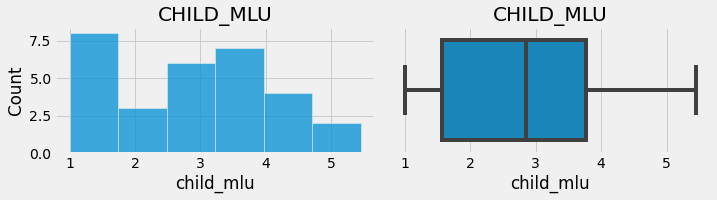

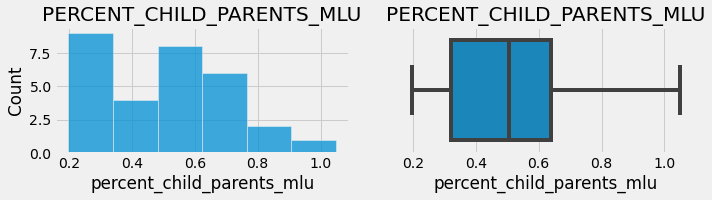

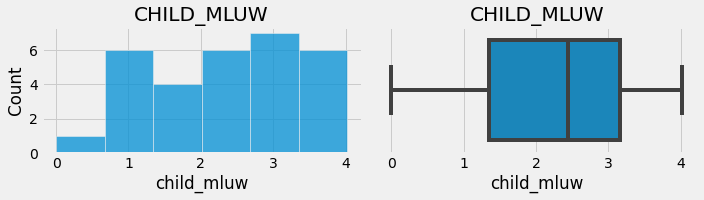

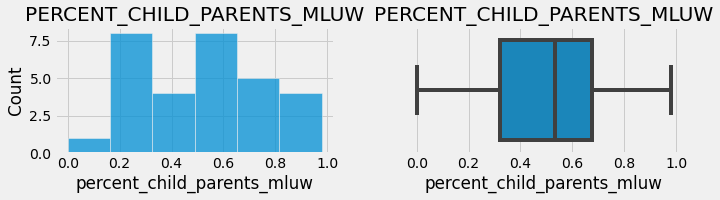

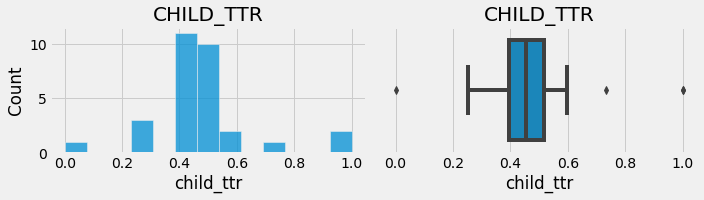

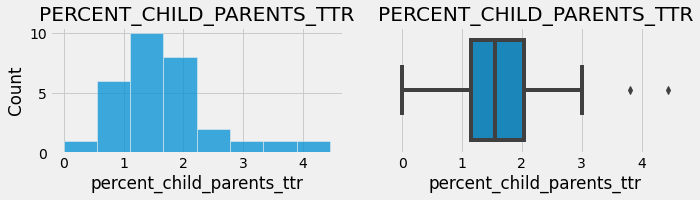

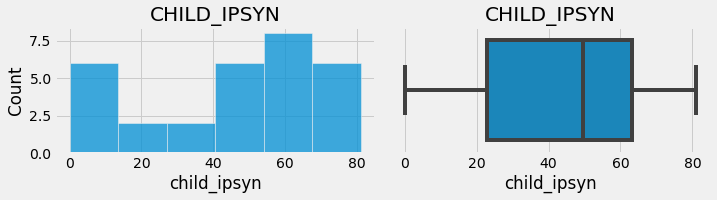

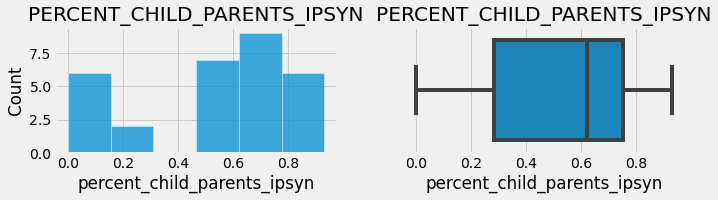

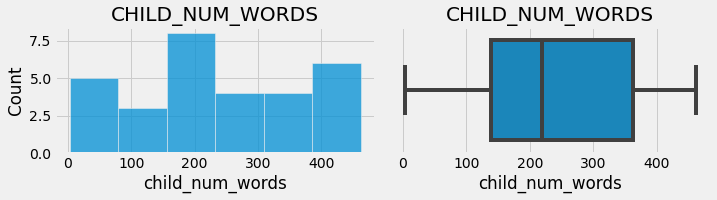

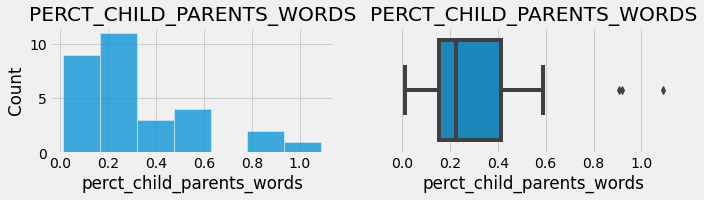

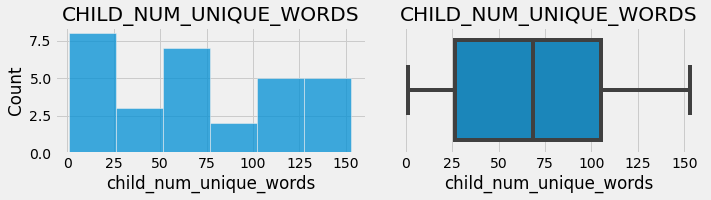

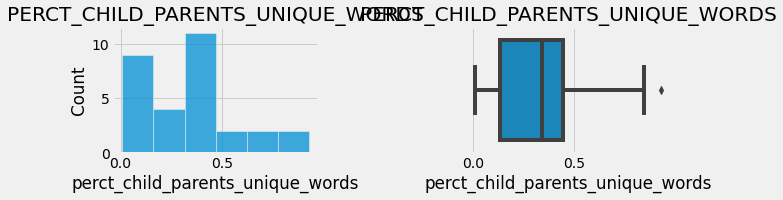

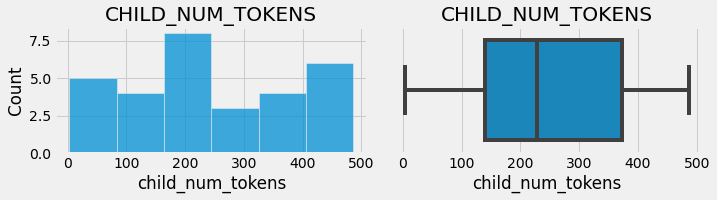

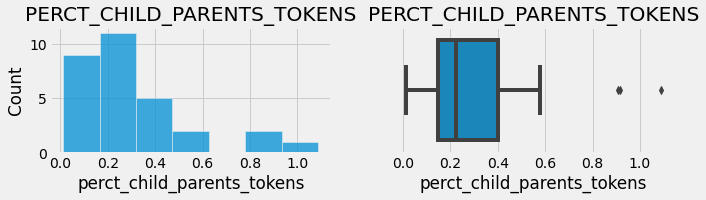

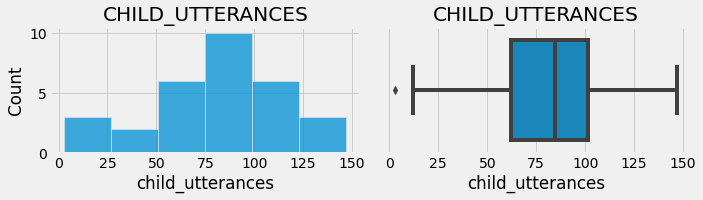

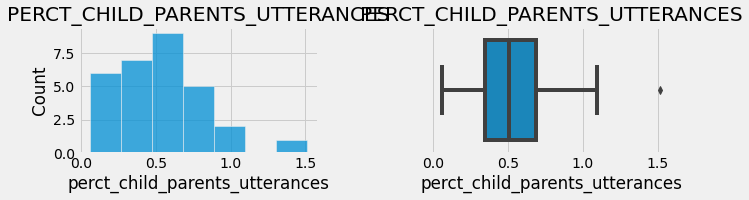

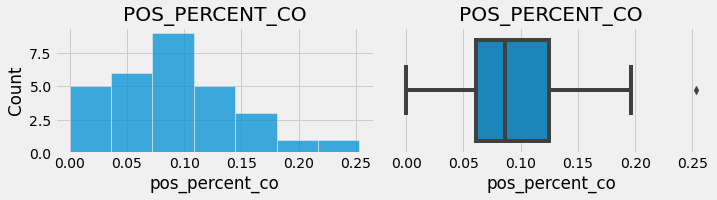

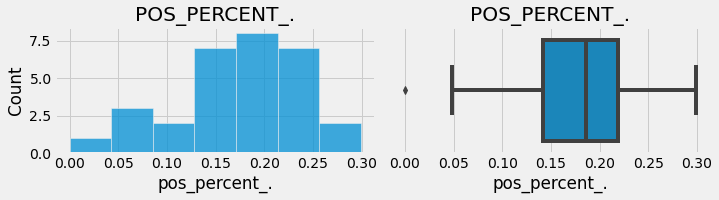

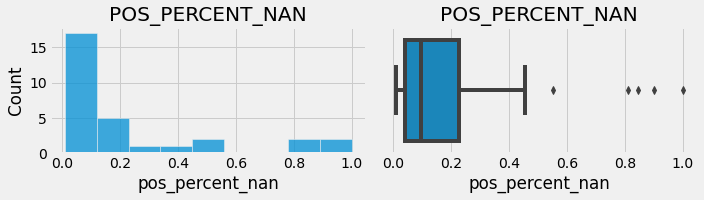

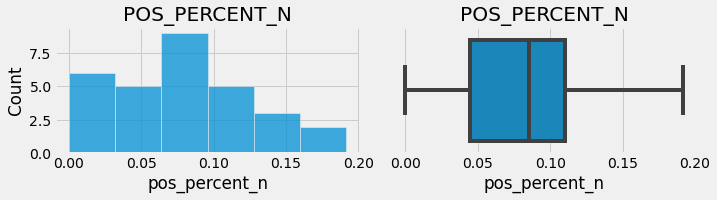

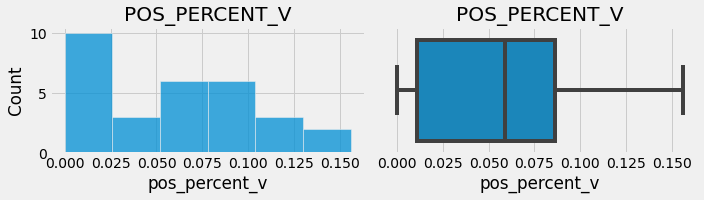

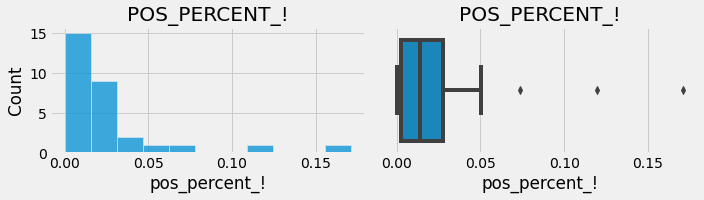

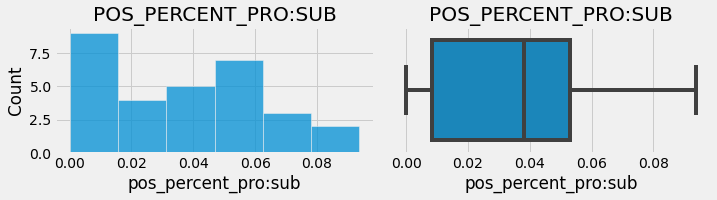

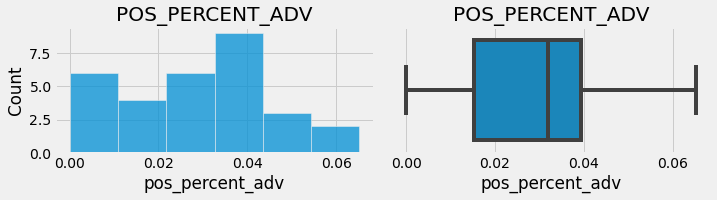

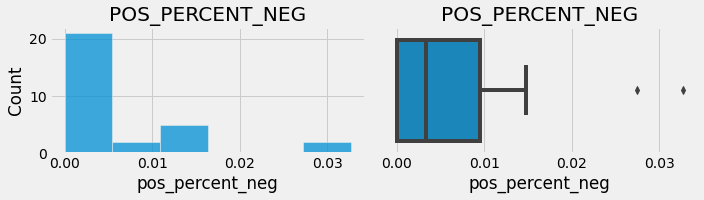

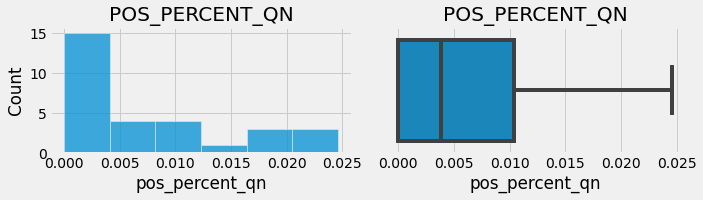

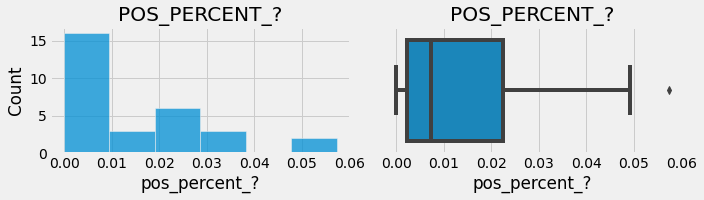

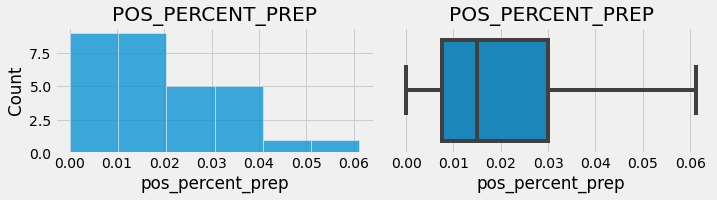

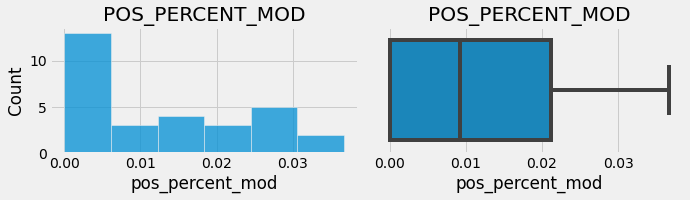

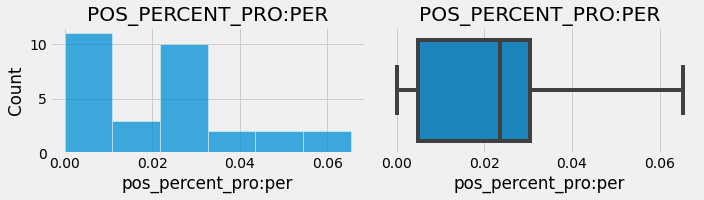

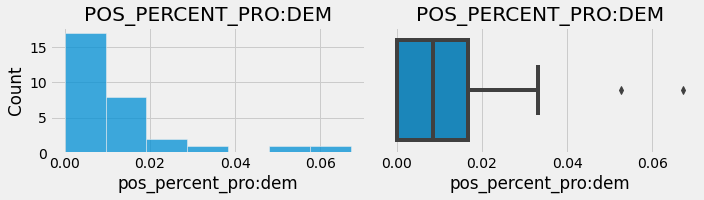

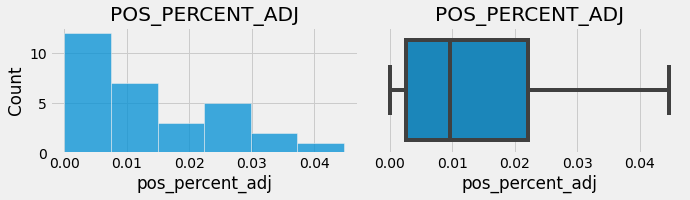

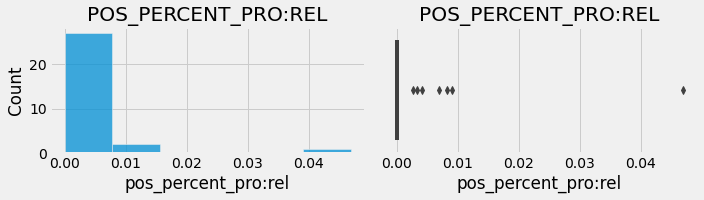

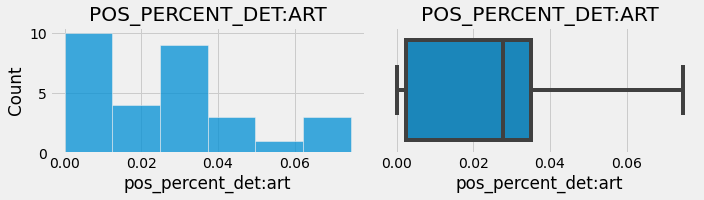

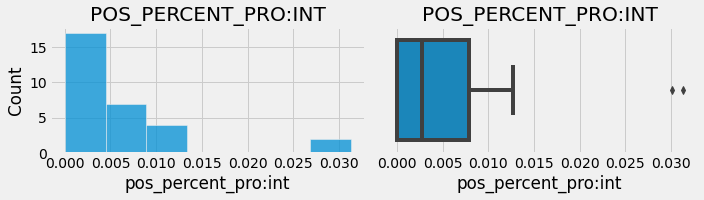

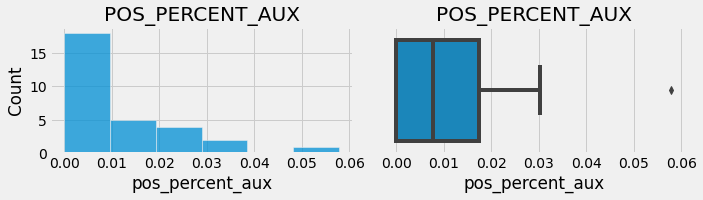

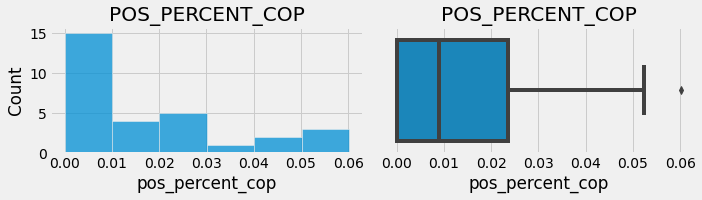

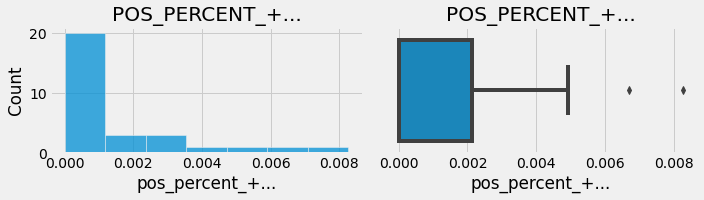

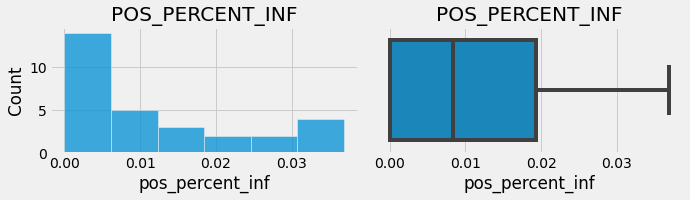

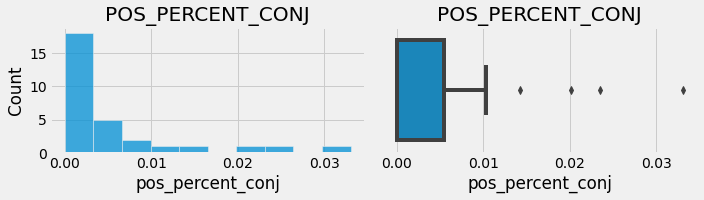

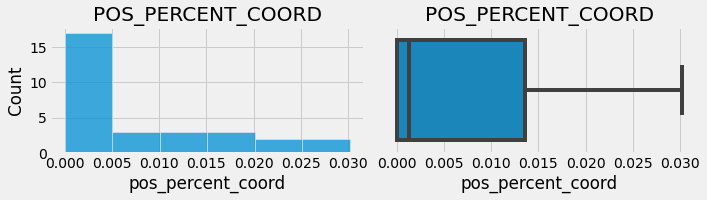

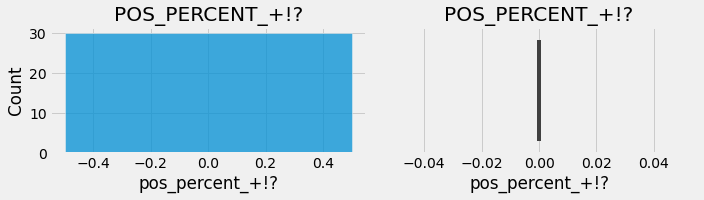

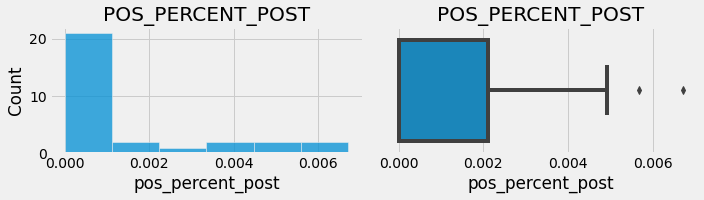

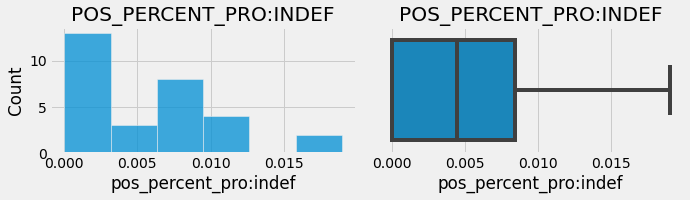

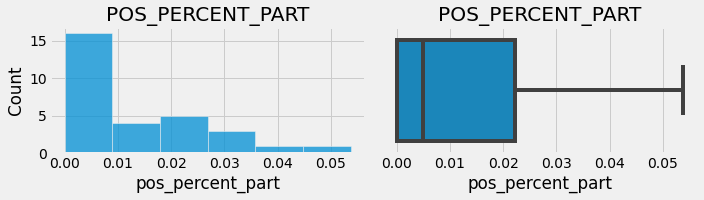

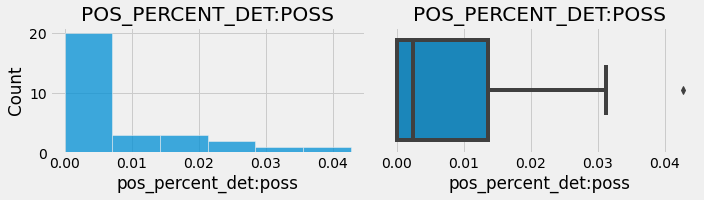

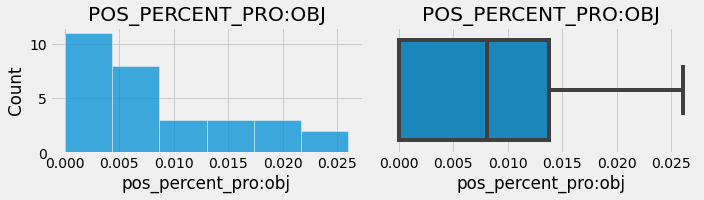

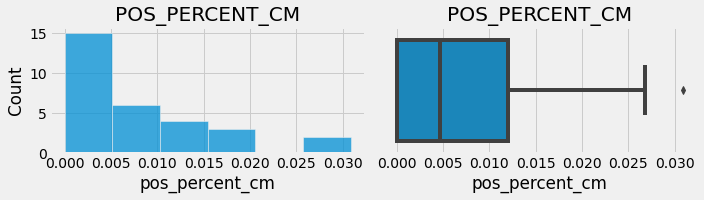

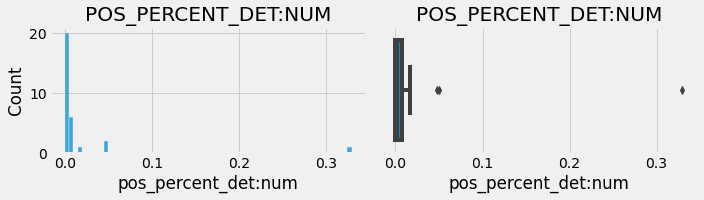

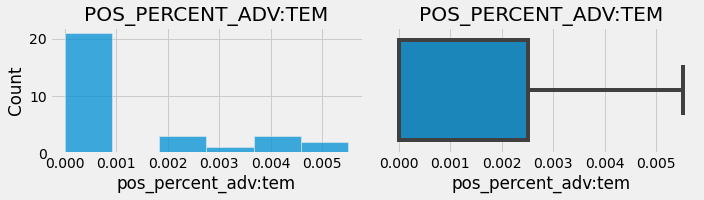

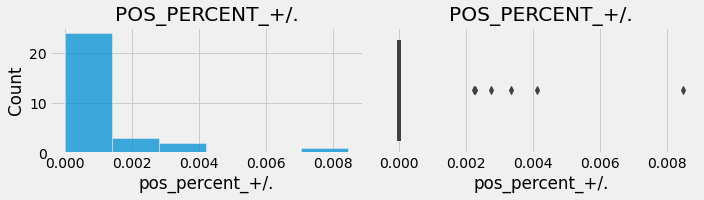

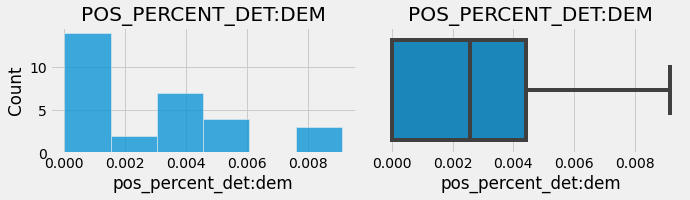

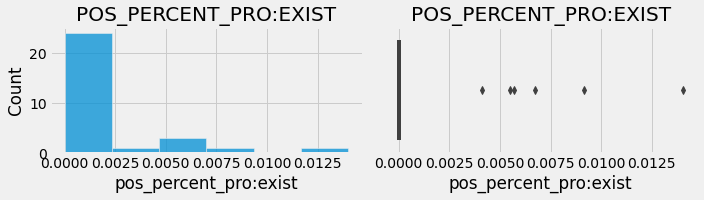

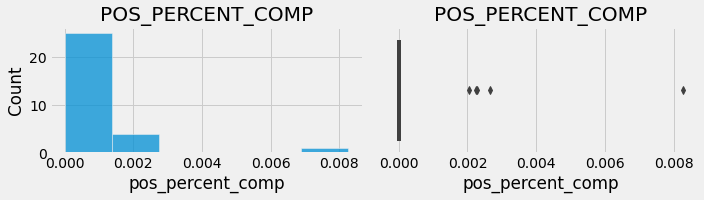

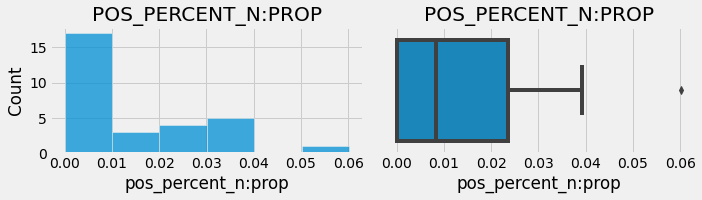

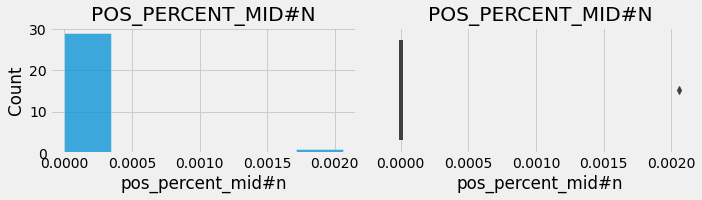

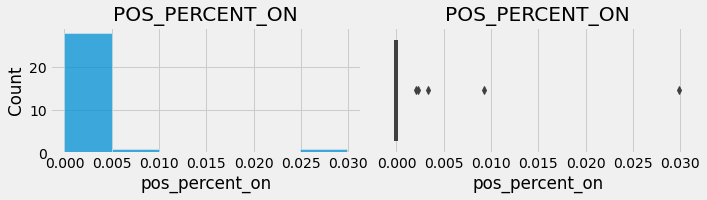

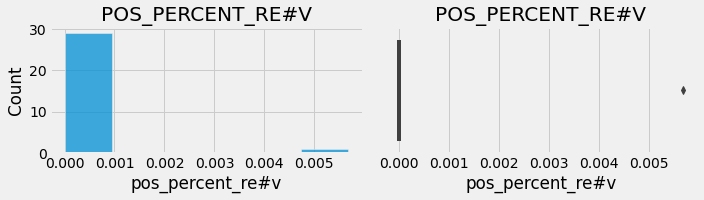

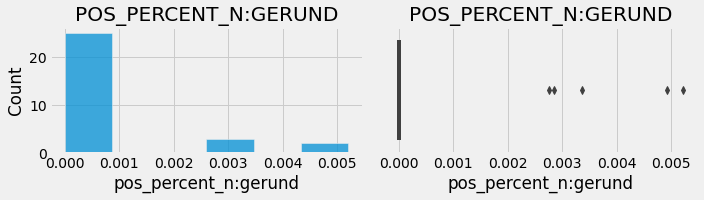

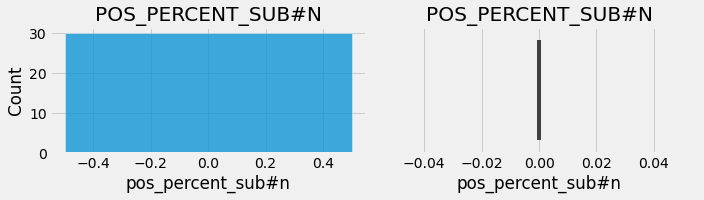

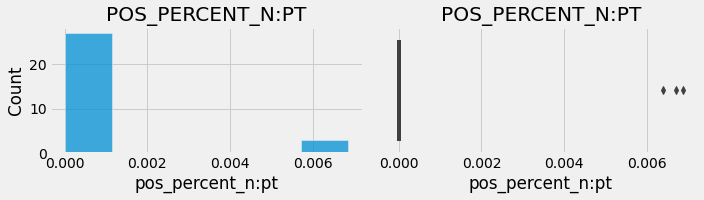

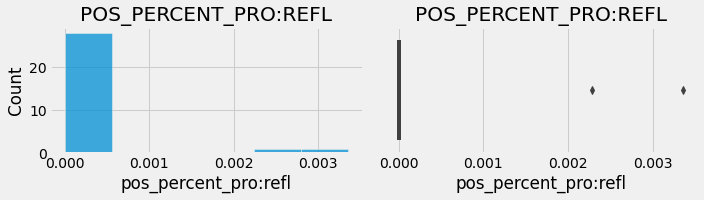

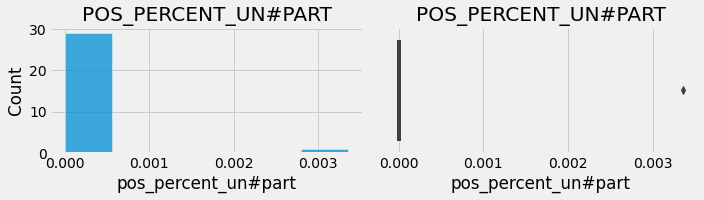

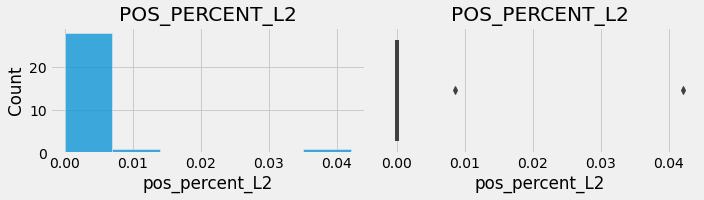

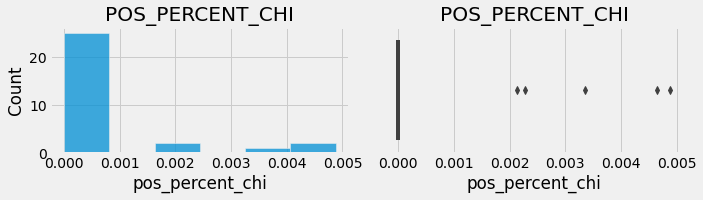

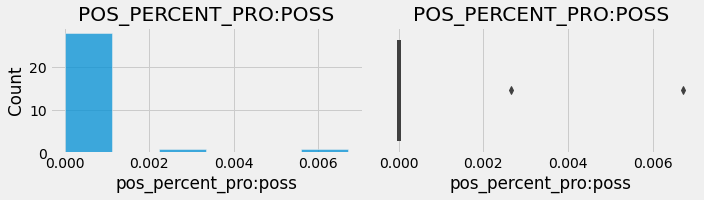

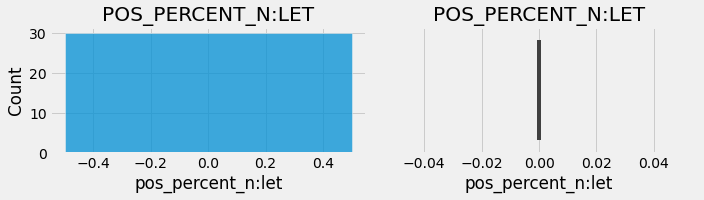

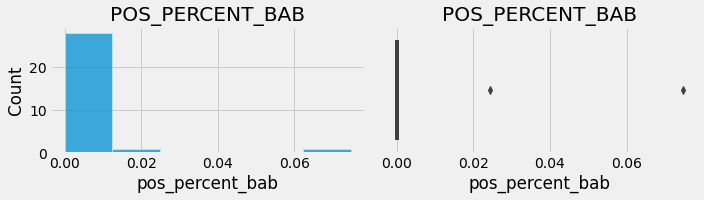

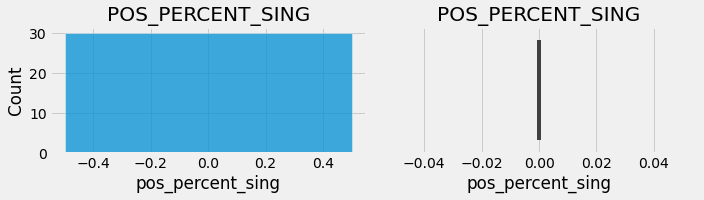

In [35]:
# iterate over columns
for col in X_train.columns:
    ####### create figure layout #######
    fig, axs = plt.subplots(nrows = 1, ncols = 2, 
                            figsize=(10,3), tight_layout = True) # axs is a (1,2) nd-array

    # plot histogram to check normality
    sns.histplot(data=X_train, x=col, ax=axs[0])
    sns.boxplot(data=X_train, x=col, ax=axs[1])
    # plot details
    axs[0].set_title(col.upper())
    axs[1].set_title(col.upper())
    # display
    plt.show()

**Most features are not normally distributed with some outliers ---> initial guess = RobustScaler**

In [36]:
# define scaler object
rs = RobustScaler(
    with_centering=True, with_scaling=True, 
    quantile_range=(25.0, 75.0), copy=True
    )

# fit to data and get scaled dataframe
X_train_scaled = pd.DataFrame(data=rs.fit_transform(X_train), columns=X_train.columns)

# inspect values
display("X_train", X_train.head(), "X_train_scaled", X_train_scaled.head())

'X_train'

,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,perct_child_parents_words,child_num_unique_words,perct_child_parents_unique_words,child_num_tokens,perct_child_parents_tokens,child_utterances,perct_child_parents_utterances,pos_percent_co,pos_percent_.,pos_percent_nan,pos_percent_n,pos_percent_v,pos_percent_!,pos_percent_pro:sub,pos_percent_adv,pos_percent_neg,pos_percent_qn,pos_percent_?,pos_percent_prep,pos_percent_mod,pos_percent_pro:per,pos_percent_pro:dem,pos_percent_adj,pos_percent_pro:rel,pos_percent_det:art,pos_percent_pro:int,pos_percent_aux,pos_percent_cop,pos_percent_+...,pos_percent_inf,pos_percent_conj,pos_percent_coord,pos_percent_+!?,pos_percent_post,pos_percent_pro:indef,pos_percent_part,pos_percent_det:poss,pos_percent_pro:obj,pos_percent_cm,pos_percent_det:num,pos_percent_adv:tem,pos_percent_+/.,pos_percent_det:dem,pos_percent_pro:exist,pos_percent_comp,pos_percent_n:prop,pos_percent_mid#n,pos_percent_on,pos_percent_re#v,pos_percent_n:gerund,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
0,3.067,0.503,3.316,0.694,0.397,1.491,18,0.212,94,0.095,28,0.133,94,0.088,30,0.174,0.021,0.181,0.117,0.191,0.053,0.021,0.021,0.032,0.000,0.000,0.000,0.011,0.000,0.000,0.000,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.011,0.330,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,2.630,0.371,2.254,0.396,0.479,2.042,43,0.531,234,0.217,72,0.335,242,0.210,92,0.571,0.169,0.219,0.120,0.062,0.025,0.008,0.021,0.033,0.004,0.008,0.025,0.029,0.004,0.021,0.000,0.021,0.004,0.021,0.008,0.021,0.004,0.008,0.021,0.000,0.021,0.000,0.000,0.000,0.054,0.000,0.017,0.008,0.004,0.000,0.000,0.004,0.000,0.008,0.029,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,2.640,0.558,2.060,0.549,0.274,0.910,44,0.629,380,0.483,70,0.374,383,0.455,139,0.808,0.157,0.256,0.057,0.044,0.084,0.029,0.023,0.065,0.000,0.010,0.018,0.010,0.016,0.065,0.003,0.003,0.000,0.021,0.003,0.000,0.005,0.003,0.013,0.000,0.003,0.000,0.000,0.008,0.003,0.003,0.005,0.003,0.050,0.003,0.000,0.000,0.000,0.000,0.039,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,3.629,0.497,2.598,0.431,0.445,1.920,66,0.742,372,0.266,122,0.433,377,0.251,105,0.528,0.098,0.252,0.008,0.130,0.072,0.016,0.034,0.032,0.000,0.019,0.003,0.032,0.021,0.032,0.019,0.032,0.000,0.032,0.000,0.008,0.016,0.000,0.005,0.005,0.005,0.000,0.000,0.008,0.013,0.013,0.008,0.005,0.048,0.003,0.000,0.005,0.000,0.003,0.021,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.000
4,1.333,0.317,1.074,0.331,0.397,1.487,10,0.145,205,0.197,26,0.123,205,0.184,147,0.576,0.146,0.220,0.454,0.044,0.005,0.024,0.000,0.005,0.000,0.000,0.020,0.000,0.000,0.000,0.010,0.005,0.000,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.005,0.005,0.000,0.005,0.000,0.000,0.000,0.000,0.000,0.039,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.000


'X_train_scaled'

,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,perct_child_parents_words,child_num_unique_words,perct_child_parents_unique_words,child_num_tokens,perct_child_parents_tokens,child_utterances,perct_child_parents_utterances,pos_percent_co,pos_percent_.,pos_percent_nan,pos_percent_n,pos_percent_v,pos_percent_!,pos_percent_pro:sub,pos_percent_adv,pos_percent_neg,pos_percent_qn,pos_percent_?,pos_percent_prep,pos_percent_mod,pos_percent_pro:per,pos_percent_pro:dem,pos_percent_adj,pos_percent_pro:rel,pos_percent_det:art,pos_percent_pro:int,pos_percent_aux,pos_percent_cop,pos_percent_+...,pos_percent_inf,pos_percent_conj,pos_percent_coord,pos_percent_+!?,pos_percent_post,pos_percent_pro:indef,pos_percent_part,pos_percent_det:poss,pos_percent_pro:obj,pos_percent_cm,pos_percent_det:num,pos_percent_adv:tem,pos_percent_+/.,pos_percent_det:dem,pos_percent_pro:exist,pos_percent_comp,pos_percent_n:prop,pos_percent_mid#n,pos_percent_on,pos_percent_re#v,pos_percent_n:gerund,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
0,0.097,-0.009,0.485,0.458,-0.486,-0.070,-0.778,-0.874,-0.564,-0.493,-0.514,-0.659,-0.576,-0.531,-1.389,-0.965,-1.020,-0.063,0.124,1.600,-0.079,0.285,-0.377,0.002,-0.352,-0.367,-0.370,-0.193,-0.438,-0.926,-0.499,0.049,0.000,-0.847,-0.344,-0.445,-0.381,0.000,-0.434,0.000,-0.096,0.000,0.000,-0.531,-0.222,-0.178,-0.589,0.497,41.581,0.000,0.000,-0.581,0.000,0.000,-0.354,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,-0.101,-0.428,-0.101,-0.383,0.198,0.557,-0.160,-0.195,0.063,-0.029,0.044,-0.013,0.058,-0.046,0.191,0.202,1.293,0.430,0.139,-0.358,-0.457,-0.230,-0.391,0.049,0.082,0.432,0.863,0.630,-0.244,-0.118,-0.499,0.565,0.004,-0.214,0.700,0.743,-0.205,3.882,0.633,0.000,1.420,0.000,0.000,-0.531,2.187,-0.178,0.613,0.299,0.234,0.000,0.000,0.355,0.000,0.008,0.879,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,-0.097,0.164,-0.208,0.048,-1.510,-0.730,-0.136,0.013,0.716,0.986,0.019,0.114,0.662,0.930,1.389,0.898,1.094,0.907,-0.196,-0.625,0.324,0.579,-0.327,1.394,-0.352,0.642,0.539,-0.202,0.300,1.627,-0.344,-0.364,0.000,-0.207,-0.015,-0.445,-0.158,1.226,0.240,0.000,0.096,0.000,0.000,0.399,-0.105,0.014,-0.209,-0.174,6.008,1.037,0.000,-0.581,0.000,0.000,1.316,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.352,-0.029,0.089,-0.285,-0.082,0.419,0.407,0.253,0.680,0.157,0.679,0.301,0.636,0.117,0.522,0.073,0.180,0.857,-0.462,0.670,0.166,0.073,-0.081,-0.002,-0.352,1.427,-0.238,0.760,0.562,0.319,0.605,1.141,0.000,0.129,-0.344,0.013,0.297,0.000,-0.160,0.972,0.293,0.000,0.000,0.414,0.372,0.794,-0.010,0.051,5.772,1.054,0.000,0.621,0.000,0.003,0.551,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.000
4,-0.690,-0.600,-0.752,-0.568,-0.488,-0.075,-0.975,-1.016,-0.067,-0.106,-0.540,-0.691,-0.101,-0.148,1.592,0.217,0.933,0.437,1.931,-0.632,-0.721,0.408,-0.854,-1.127,-0.352,-0.367,0.600,-0.672,-0.438,-0.926,0.081,-0.248,0.000,-0.548,-0.344,-0.445,-0.381,0.000,-0.434,0.000,-0.096,0.000,0.000,-0.531,-0.222,0.180,-0.234,-0.393,0.329,0.000,0.000,-0.581,0.000,0.000,1.310,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.000


In [37]:
# inspect statistics
display("X_train", X_train.describe(), "X_train_scaled", X_train_scaled.describe())

'X_train'

,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,perct_child_parents_words,child_num_unique_words,perct_child_parents_unique_words,child_num_tokens,perct_child_parents_tokens,child_utterances,perct_child_parents_utterances,pos_percent_co,pos_percent_.,pos_percent_nan,pos_percent_n,pos_percent_v,pos_percent_!,pos_percent_pro:sub,pos_percent_adv,pos_percent_neg,pos_percent_qn,pos_percent_?,pos_percent_prep,pos_percent_mod,pos_percent_pro:per,pos_percent_pro:dem,pos_percent_adj,pos_percent_pro:rel,pos_percent_det:art,pos_percent_pro:int,pos_percent_aux,pos_percent_cop,pos_percent_+...,pos_percent_inf,pos_percent_conj,pos_percent_coord,pos_percent_+!?,pos_percent_post,pos_percent_pro:indef,pos_percent_part,pos_percent_det:poss,pos_percent_pro:obj,pos_percent_cm,pos_percent_det:num,pos_percent_adv:tem,pos_percent_+/.,pos_percent_det:dem,pos_percent_pro:exist,pos_percent_comp,pos_percent_n:prop,pos_percent_mid#n,pos_percent_on,pos_percent_re#v,pos_percent_n:gerund,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
count,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000
mean,2.866,0.501,2.337,0.520,0.476,1.731,44.233,0.543,236.267,0.311,69.833,0.343,247.000,0.305,79.533,0.526,0.092,0.176,0.227,0.078,0.058,0.025,0.035,0.029,0.006,0.007,0.014,0.019,0.012,0.022,0.012,0.013,0.003,0.027,0.005,0.011,0.016,0.001,0.012,0.005,0.007,0.000,0.001,0.005,0.012,0.008,0.008,0.007,0.017,0.001,0.001,0.003,0.002,0.001,0.015,0.000,0.002,0.000,0.001,0.000,0.001,0.000,0.000,0.002,0.001,0.000,0.000,0.003,0.000
std,1.306,0.215,1.088,0.232,0.189,0.893,25.919,0.304,140.931,0.273,47.391,0.249,149.381,0.272,34.864,0.314,0.057,0.068,0.297,0.051,0.046,0.038,0.028,0.019,0.008,0.008,0.015,0.016,0.012,0.019,0.016,0.012,0.009,0.023,0.008,0.013,0.018,0.002,0.013,0.008,0.009,0.000,0.002,0.006,0.014,0.011,0.008,0.008,0.060,0.002,0.002,0.003,0.003,0.002,0.017,0.000,0.006,0.001,0.002,0.000,0.002,0.001,0.001,0.008,0.001,0.001,0.000,0.014,0.000
min,1.000,0.198,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.012,1.000,0.009,3.000,0.011,3.000,0.059,0.000,0.000,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.571,0.322,1.353,0.321,0.397,1.148,22.750,0.282,139.250,0.153,26.500,0.132,140.000,0.148,62.250,0.344,0.061,0.142,0.041,0.044,0.011,0.002,0.009,0.015,0.000,0.000,0.002,0.008,0.000,0.005,0.000,0.003,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,2.853,0.506,2.437,0.532,0.455,1.552,49.500,0.623,220.000,0.224,68.500,0.339,228.500,0.221,84.500,0.503,0.087,0.186,0.094,0.086,0.059,0.014,0.038,0.032,0.003,0.004,0.007,0.015,0.009,0.024,0.008,0.010,0.000,0.028,0.003,0.008,0.009,0.000,0.008,0.000,0.001,0.000,0.000,0.004,0.005,0.002,0.008,0.005,0.002,0.000,0.000,0.003,0.000,0.000,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,3.774,0.638,3.165,0.675,0.517,2.028,63.250,0.752,362.750,0.415,105.250,0.444,373.500,0.399,101.500,0.684,0.125,0.219,0

'X_train_scaled'

,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,perct_child_parents_words,child_num_unique_words,perct_child_parents_unique_words,child_num_tokens,perct_child_parents_tokens,child_utterances,perct_child_parents_utterances,pos_percent_co,pos_percent_.,pos_percent_nan,pos_percent_n,pos_percent_v,pos_percent_!,pos_percent_pro:sub,pos_percent_adv,pos_percent_neg,pos_percent_qn,pos_percent_?,pos_percent_prep,pos_percent_mod,pos_percent_pro:per,pos_percent_pro:dem,pos_percent_adj,pos_percent_pro:rel,pos_percent_det:art,pos_percent_pro:int,pos_percent_aux,pos_percent_cop,pos_percent_+...,pos_percent_inf,pos_percent_conj,pos_percent_coord,pos_percent_+!?,pos_percent_post,pos_percent_pro:indef,pos_percent_part,pos_percent_det:poss,pos_percent_pro:obj,pos_percent_cm,pos_percent_det:num,pos_percent_adv:tem,pos_percent_+/.,pos_percent_det:dem,pos_percent_pro:exist,pos_percent_comp,pos_percent_n:prop,pos_percent_mid#n,pos_percent_on,pos_percent_re#v,pos_percent_n:gerund,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
count,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000
mean,0.006,-0.016,-0.055,-0.034,0.178,0.204,-0.130,-0.169,0.073,0.330,0.017,0.013,0.079,0.332,-0.127,0.069,0.091,-0.128,0.713,-0.116,-0.022,0.422,-0.065,-0.128,0.261,0.295,0.333,0.170,0.135,-0.065,0.226,0.154,0.003,-0.030,0.350,0.185,0.312,0.612,0.160,0.852,0.431,0.000,0.569,0.092,0.315,0.398,0.008,0.204,1.889,0.455,0.001,0.017,0.002,0.001,0.269,0.000,0.002,0.000,0.001,0.000,0.001,0.000,0.000,0.002,0.001,0.000,0.000,0.003,0.000
std,0.593,0.682,0.601,0.656,1.575,1.015,0.640,0.647,0.631,1.041,0.602,0.800,0.640,1.082,0.888,0.924,0.892,0.883,1.596,0.764,0.608,1.489,0.637,0.774,0.862,0.785,0.745,0.720,0.587,0.748,0.942,0.617,0.009,0.700,1.004,0.748,0.767,1.042,0.646,1.487,0.693,0.000,0.976,0.658,0.638,0.806,0.578,0.704,7.655,0.748,0.002,0.657,0.003,0.002,0.704,0.000,0.006,0.001,0.002,0.000,0.002,0.001,0.001,0.008,0.001,0.001,0.000,0.014,0.000
min,-0.841,-0.975,-1.345,-1.503,-3.792,-1.764,-1.222,-1.324,-0.971,-0.811,-0.857,-1.057,-0.966,-0.837,-2.076,-1.305,-1.352,-2.402,-0.462,-1.296,-0.786,-0.557,-0.854,-1.330,-0.352,-0.367,-0.370,-0.672,-0.438,-0.926,-0.499,-0.499,0.000,-0.847,-0.344,-0.445,-0.381,0.000,-0.434,0.000,-0.096,0.000,0.000,-0.531,-0.222,-0.178,-0.589,-0.393,-0.290,0.000,0.000,-0.581,0.000,0.000,-0.354,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-0.582,-0.582,-0.598,-0.595,-0.488,-0.459,-0.660,-0.724,-0.361,-0.271,-0.533,-0.664,-0.379,-0.293,-0.567,-0.465,-0.399,-0.565,-0.286,-0.625,-0.641,-0.464,-0.663,-0.691,-0.352,-0.367,-0.253,-0.327,-0.438,-0.738,-0.499,-0.361,0.000,-0.772,-0.344,-0.445,-0.381,0.000,-0.434,0.000,-0.096,0.000,0.000,-0.531,-0.222,-0.178,-0.589,-0.393,-0.290,0.000,0.000,-0.581,0.000,0.000,-0.354,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.418,0.418,0.402,0.405,0.512,

## 8.4 - Discretizing

In [38]:
# TO-DO

## 8.5 - Categorical encoding

In [39]:
# TO-DO

## 8.6 - Time-cyclic variables

In [40]:
# TO-DO

## 8.7 - Response Variable Transformation

In [41]:
# TO-DO

## 8.8 - Cyclic time variables transformation

In [42]:
# TO-DO

## 8.9 - sklearn.pipelines

In [43]:
# TO-DO

## 8.10 - Final check

In [44]:
# TO-DO

# 9 - Metrics

*What will be the model output?* 
- Label or probability?

*What will be the main model metric? And the auxiliary metrics?*
- Accuracy
- Recall
- Precision
- F1-score
- ROC-AUC
- Precision-recall AUC
- Cross Entropy (log-loss)
- confusion matrix

In [45]:
# TO-DO

# 10 - Feature Selection

*Select features for modelling*

## 10.1 - Feature coefficients

In [46]:
# instanciate LR
lr = LogisticRegression(n_jobs=-1, max_iter=1000, random_state=seed)

# fit model to data
lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=0)

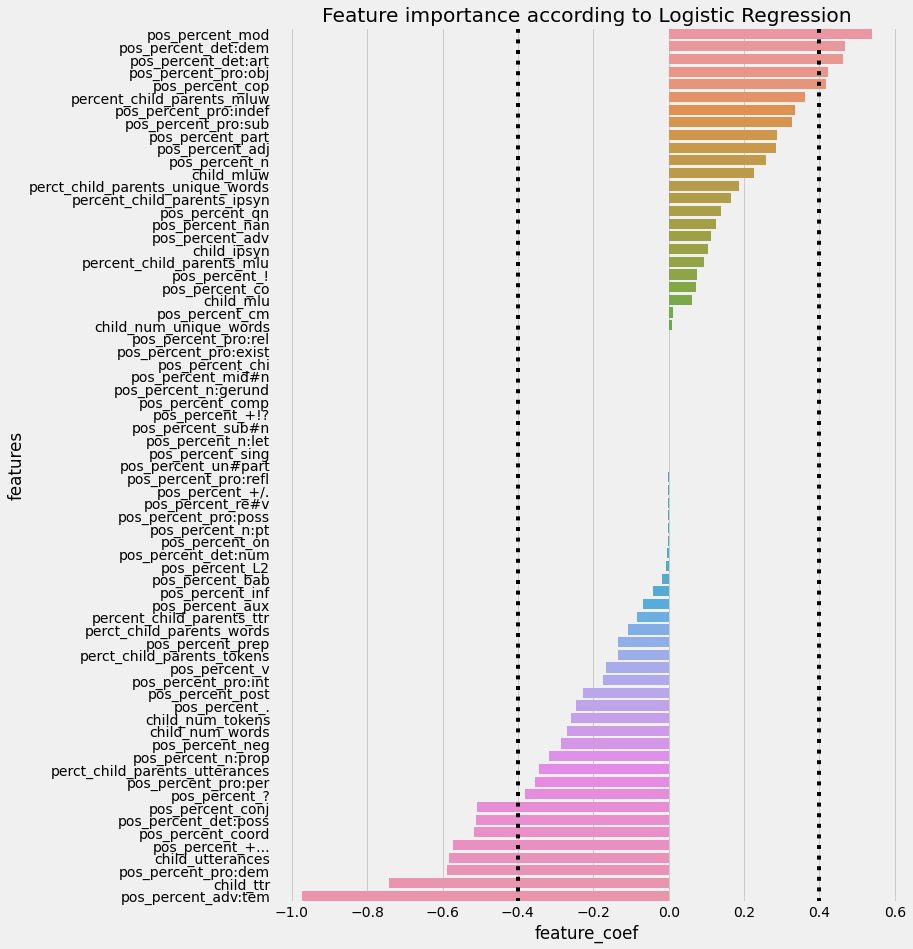

In [47]:
# create a dataframe with feature importances
df_f_coef = pd.DataFrame(data=lr.coef_, columns=X_train.columns).T
# reset index and rename column
df_f_coef = df_f_coef.reset_index()
df_f_coef = df_f_coef.rename(columns={"index":"features", 0:"feature_coef"})
# create a new column with absolute value of coef
df_f_coef["abs_coef"] = df_f_coef["feature_coef"].apply(lambda x: abs(x))
# define column names
df_f_coef = df_f_coef.sort_values(by="feature_coef", ascending=False, ignore_index=True)

# define figure size
fig = plt.figure(figsize=(10, 15))

# plot
sns.barplot(data=df_f_coef, x="feature_coef", y="features")
# define details
plt.title("Feature importance according to Logistic Regression", loc="center")
plt.axvline(-0.4, linestyle=":", color="black")
plt.axvline(0.4, linestyle=":", color="black")
plt.show()

In [48]:
# get features whose abs coef is > 0.4
# 0.4 was chosen using the elbow method approach
f_selected_lr = df_f_coef.loc[df_f_coef["abs_coef"] > 0.4, "features"].tolist()
# print info
print(
    f'\n{len(f_selected_lr)} features selected...\n',
)
f_selected_lr


13 features selected...



['pos_percent_mod',
 'pos_percent_det:dem',
 'pos_percent_det:art',
 'pos_percent_pro:obj',
 'pos_percent_cop',
 'pos_percent_conj',
 'pos_percent_det:poss',
 'pos_percent_coord',
 'pos_percent_+...',
 'child_utterances',
 'pos_percent_pro:dem',
 'child_ttr',
 'pos_percent_adv:tem']

## 10.2 - Feature importance

In [49]:
# define model
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight=None, random_state=seed)

# fit model to data
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

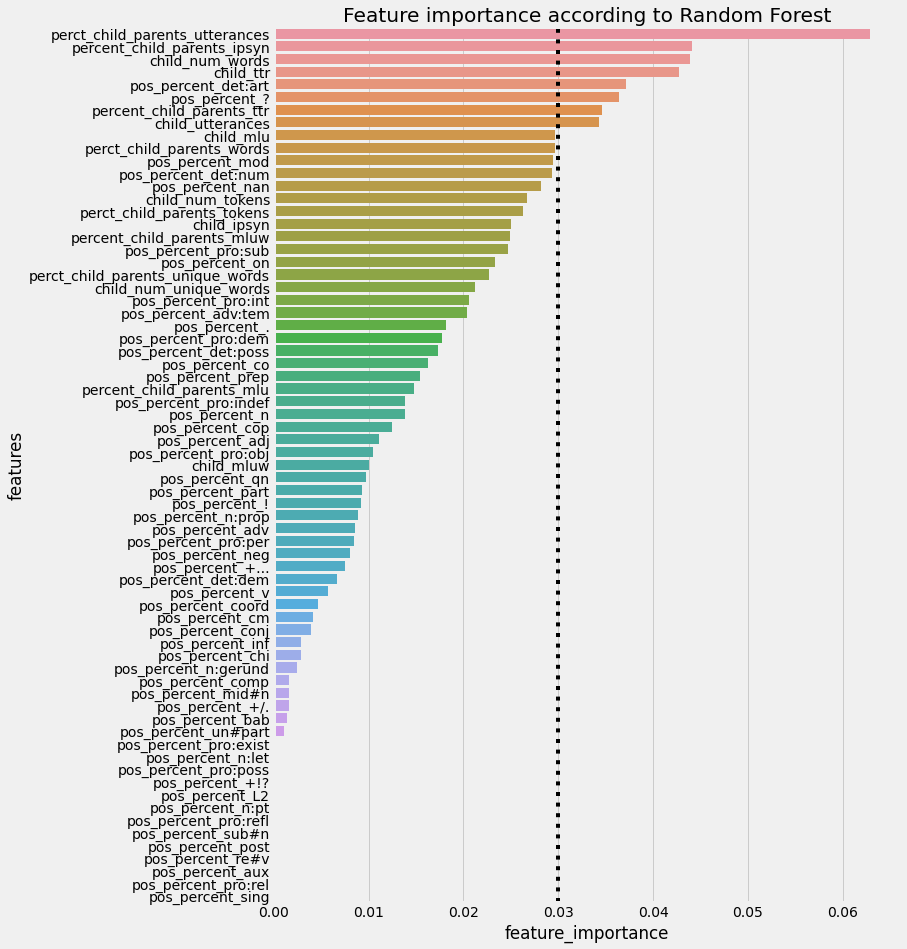

In [50]:
# create a dataframe with feature importances
df_f_importance = pd.DataFrame(data=rf.feature_importances_, index=X_train.columns)
# reset index and rename column
df_f_importance = df_f_importance.reset_index()
df_f_importance = df_f_importance.rename(columns={"index":"features", 0:"feature_importance"})
# define column names
df_f_importance = df_f_importance.sort_values(by="feature_importance", ascending=False)

# define figure size
fig = plt.figure(figsize=(10, 15))

# plot
sns.barplot(data=df_f_importance, x="feature_importance", y="features")
# define details
plt.title("Feature importance according to Random Forest", loc="center")
plt.axvline(0.03, linestyle=":", color="black")
plt.show()

In [51]:
# get features whose feature_importance is > 0.03
# 0.3 was chosen using the elbow method approach
f_selected_rf = df_f_importance.loc[df_f_importance["feature_importance"] > 0.03, "features"].tolist()
# print info
print(
    f'\n{len(f_selected_rf)} features selected...\n',
)
f_selected_rf


8 features selected...



['perct_child_parents_utterances',
 'percent_child_parents_ipsyn',
 'child_num_words',
 'child_ttr',
 'pos_percent_det:art',
 'pos_percent_?',
 'percent_child_parents_ttr',
 'child_utterances']

## 10.3 - Buruta algorithm

In [52]:
# install boruta
!pip install -q Boruta

In [53]:
# import required libraries
from boruta import BorutaPy

# define model
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight=None)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=seed)

# find all relevant features - 5 features should be selected
feat_selector.fit(X_train.values, y_train.values)

# get number of selected features
print(
    f"\n{'*'*49}\n\n"
    f"Number of selected features: {feat_selector.n_features_}"
    f"\n\n{'*'*49}\n"
)


*************************************************

Number of selected features: 0

*************************************************



## 10.4 - Mutual Information

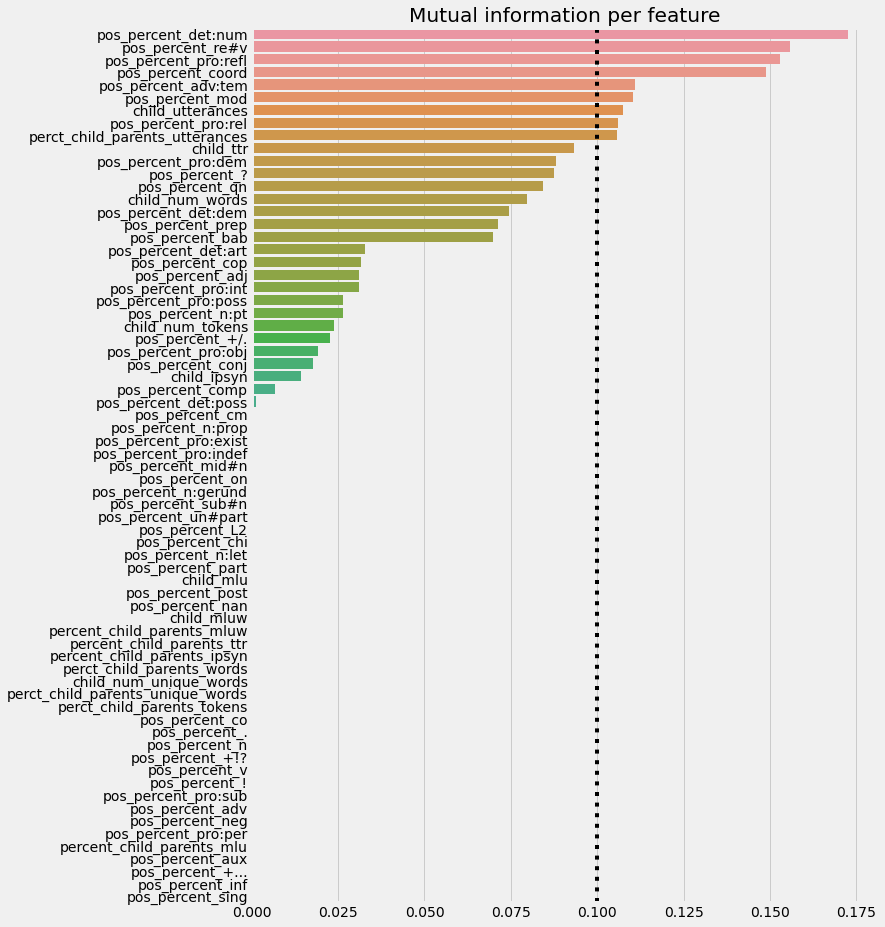

In [54]:
# calculate mutual information between features and target
mutual_info = mutual_info_classif(X_train_scaled, y_train, random_state=seed)

# create a series from mutual information
mutual_info_series = pd.Series(mutual_info)
# add column labels as index
mutual_info_series.index=X_train.columns
# sort in descending order
mutual_info_series = mutual_info_series.sort_values(ascending=False)

# define figure size
fig = plt.figure(figsize=(10, 15))

# plot
sns.barplot(y=mutual_info_series.index, x=mutual_info_series)
# define details
plt.title("Mutual information per feature", loc="center")
plt.axvline(0.1, linestyle=":", color="black")
plt.show()

In [55]:
# get features whose mutual_info_series > 0.1
# 0.1 was chosen more or less using the elbow method approach
f_selected_mi = mutual_info_series[mutual_info_series > 0.1].index.tolist()
# print info
print(
    f'\n{len(f_selected_mi)} features selected...\n',
)
f_selected_mi


9 features selected...



['pos_percent_det:num',
 'pos_percent_re#v',
 'pos_percent_pro:refl',
 'pos_percent_coord',
 'pos_percent_adv:tem',
 'pos_percent_mod',
 'child_utterances',
 'pos_percent_pro:rel',
 'perct_child_parents_utterances']

## 10.5 - Final feaures

In [56]:
# define feature with OR statement
f_or = list((set(f_selected_mi + f_selected_rf + f_selected_lr)))
# print report
print(
    f'\n{"*"*49}\n\n'
    f'Number of feature with OR statement between feature selection methods: {len(f_or)}\n'
)

# define feature with OR statement
f_and = list(set(f_selected_mi) & set(f_selected_rf) & set(f_selected_lr))
# print report
print(
    f'{"*"*49}\n\n'
    f'Number of feature with AND statement between feature selection methods: {len(f_and)}\n'
    f'Selected features are: {f_and}'
    f'\n\n{"*"*49}\n'
)


*************************************************

Number of feature with OR statement between feature selection methods: 22

*************************************************

Number of feature with AND statement between feature selection methods: 1
Selected features are: ['child_utterances']

*************************************************



# 11 - Modelling

## 11.1 - Dummy model

*The easiest model without any coding*

## 11.2 - Baseline model

*The fastest model to build*

In [57]:
# TO-DO

## 11.3 - Best model

*The best model of all*

In [58]:
# TO-DO

# 12 - Hyper-parameter tuning

*Find out the best hyper-parameters for the ML models*

*What strategy to use*
- Grid Search
- Random search
- Bayesian search
- Optuna

*How ot keep track of model performances?*
- mlflow

In [59]:
# TO-DO

# 13 - Error Analysis

*Perform error analysis to check model performance*

## 13.1 - Cross-validation

In [60]:
def get_class_metrics(y_true, y_pred, y_pred_proba):
    """Get basic classification metrics.
    
    Args
        y_true: true label for the samples.
        y_pred: predicted classes for the samples ( model.predict(X) ).
        y_pred_proba: predicted probability for the samples ( model.predict_proba(X)[:, 1] ).

    Return
        metrics: a dict with accuracy, precision, recall, 
            f1, roc-auc, precision-recall-auc scores.
    """

    # get threshold dependent metrics for the given model
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # get probability dependent metrics for the given model
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    precision_, recall_, thresholds = precision_recall_curve(y_true, y_pred_proba)
    precision_recall_auc = auc(recall_, precision_)
    log_loss_ = log_loss(y_true, y_pred_proba)

    # metrics
    metrics = {
        "accuracy":accuracy, 
        "precision":precision, 
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "precision_recall_auc": precision_recall_auc,
        "log_loss": log_loss_
    }

    return metrics


def make_scorer_precision_recall_auc_(y_true, y_pred_proba):
    """Prepare a function to be used along with sklearn.metrics.make_scorer.
    For further deatils, read:
        https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
    
    Args
        y_true: true label for the samples
        y_pred_proba: predicted probability for the samples ( model.predict_proba(X) )

    Return
        precision_recall_auc: precision-recall-auc score
    """

    # get probability dependent metrics for the given model
    precision_, recall_, thresholds = precision_recall_curve(y_true, y_pred_proba)
    precision_recall_auc = auc(recall_, precision_)

    return precision_recall_auc

In [61]:
# instanciate Leave 2 Out object
lpo = LeavePOut(2)

# print information
print(f'\nNumber of leave 2 out splits: {len([True for _ in lpo.split(X_train_scaled)])}\n')

# instanciate Leave P Out object
lpo = LeavePOut(1)

# print information
print(f'\nNumber of leave 1 out splits: {len([True for _ in lpo.split(X_train_scaled)])}\n\n')

# define stratified cv
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
# iterate over folds
for i, (train_index, val_index) in enumerate(skf.split(X_train_scaled, y_train)):
    # print info
    print(
        f'Target proportion of fold {i+1}:\n'
        f'\ttraining:    {y_train[train_index].mean():.2f}\n'
        f'\tvalidation:  {y_train[val_index].mean():.2f}'
    )


Number of leave 2 out splits: 435


Number of leave 1 out splits: 30


Target proportion of fold 1:
	training:    0.33
	validation:  0.33
Target proportion of fold 2:
	training:    0.33
	validation:  0.33
Target proportion of fold 3:
	training:    0.33
	validation:  0.33
Target proportion of fold 4:
	training:    0.33
	validation:  0.33
Target proportion of fold 5:
	training:    0.33
	validation:  0.33
Target proportion of fold 6:
	training:    0.33
	validation:  0.33
Target proportion of fold 7:
	training:    0.33
	validation:  0.33
Target proportion of fold 8:
	training:    0.33
	validation:  0.33
Target proportion of fold 9:
	training:    0.33
	validation:  0.33
Target proportion of fold 10:
	training:    0.33
	validation:  0.33


## 13.2 - Overfitting vs Wellfitting vs Underfitting

In [62]:
def explore_stratified_cv(
    X_train, 
    y_train, 
    zip_features_label, 
    zip_model_label, 
    zip_synthetic_data_label
):
    """
    Given the right inputs, it experiments combinations of predicting models,
    synthetic data generator models and features and return a dataframe
    with basic classification metrics.

    Args
        X_train: a pd.DataFrame object with features to experiment.
        y_train: a pd.DataFrame object with labels for the input X_train.
        zip_features_label: a zip object where first items are list of features
            and second items are lists of features labels to identify them
            on the reporting dataframe.
            E.g.:
                # define possible features to test
                zip_features_label = zip(
                    # available features selected
                    [["A", "B"], ["A", "C", "F"]],
                    # features selected labels
                    [["First label"], ["Second label"]]
                    )
        zip_model_label: a zip object where first items are list of ML models
            and second items are lists of model labels to identify them
            on the reporting dataframe.
            E.g.:
                # define possible models to test
                zip_model_label = zip(
                        # available models will be the "model" iterator
                        [ dummy ,  lr  ,  knn  ],
                        # available labels will be "label" iterator
                        ["Dummy", "lr" , "knn" ] 
                    )
        zip_synthetic_data_label: a zip object where first items are list of models
            to generate synthetic data and second items are lists of model labels 
            to identify them on the reporting dataframe.
            E.g.:
                # define possible synthetic data generation techniques
                zip_synthetic_data_label = zip(
                            # available models will be the "model" iterator
                            [  None  , SMOTE(random_state=0, n_jobs=-1)],
                            # available labels will be "label" iterator
                            ["Normal",       "SMOTE"                   ]
                        )

    Return
        df_metrics: a pd.DataFrame object with identification of
            ML model, data, features selected as well as basic
            classification metrics
    

    #################################################################
    # NOTE Features ending with XXX_val_enhanced_fitting_proportion #
    #################################################################

    Let's say we did a 10 fold cross-validation and we want to understand
    what mean_F1_val_enhanced_fitting_proportion means. cv_data is a dict
    with cv metrics over the 10 cv-folds.

    First: calculate the test-train proportion for F1 over the 10 cv-folds
        test_train_proportion_metric = cv_data[f"test_f1"] / cv_data[f"train_f1"]
    Second: calculate the test F1 over the 10 cv-folds        
        test_f1 = cv_data[f"test_f1"]
    Third: the half of test_train_proportion_metric + test_f1
        f1_val_enhanced_fitting_proportion = (cv_data[f"test_{metric}"] + test_train_proportion_metric)*0.5
        
        The main purpose of this metric is that:
        - Values closer to 1 means model has high F1 and is not overfitting.
        - Values closer to 0 means model with low F1 and is underfitting.
        - This way we take into account not only validation metrics but also information if model is overfitting or not.

    Fourth: calculate the mean of f1_val_enhanced_fitting_proportion over all 10 folds once
        f1_val_enhanced_fitting_proportion gives us this proportion per cv-fold.
        mean_f1_val_enhanced_fitting_proportion = np.mean(f1_val_enhanced_fitting_proportion)
    """
    #####################
    # Prepare variables #
    #####################

    # unpack zips
    zip_features_label = [*zip_features_label]
    zip_model_label = [*zip_model_label]
    zip_synthetic_data_label = [*zip_synthetic_data_label]

    # define total number of iterations
    num_iter = len(zip_features_label) * len(zip_model_label) * len(zip_synthetic_data_label)

    # define initial iter
    iter = 1

    # define dict to store metrics
    df_metrics = pd.DataFrame()

    # define precision-recall auc metric for cv
    precision_recall_auc = make_scorer(
        score_func=make_scorer_precision_recall_auc_,
        greater_is_better=True, 
        needs_proba=True, 
        needs_threshold=False
        )

    # define metrics
    metrics = {
        "PRAuc": precision_recall_auc,
        "ROC": "roc_auc", 
        "F1": "f1", 
        "Recall": "recall", 
        "Precision": "precision", 
        "Accuracy": "accuracy", 
        "NegCrossEntropy": "neg_log_loss", 
    }


    #######################################
    # Iterate possible feature selections #
    #######################################

    # iterate over possible feature combinations
    for selected_features, selected_features_label in zip_features_label:

        # filter training dataframe given the selected features
        X_train_f_selected = X_train[selected_features]

        # sanity check
        assert X_train_f_selected.shape[1] == len(selected_features), "Error of feature selection filtering!"


        ##########################
        # Iterate over ML models #
        ##########################

        # iterate over models and labels
        for ml_model, ml_label in zip_model_label:


            ################################################
            # Iterate over synthetic data model generators #
            ################################################

            # iterate over synthetic data generation models and their labels
            for synthetic_data_model, data_label in zip_synthetic_data_label:

                # print report
                print(
                    f'Perform iteration number {iter} of {num_iter} iterations...')


                ##############################################
                # Try to get cv metrics and deal with errors #
                ##############################################

                # try to get cv metrics
                try:


                    #######################################
                    # Generate synthetic data if required #    
                    #######################################

                    # check if we will use synthetic data
                    if data_label == "Normal":
                        # keep data as it is
                        X_train_modelling, y_train_modelling = X_train_f_selected.copy(), y_train.copy()
                    # we will not use normal data
                    else:
                        # create modelling data
                        X_train_modelling, y_train_modelling = synthetic_data_model.fit_resample(X_train_f_selected.copy(), y_train.copy())


                    ######################################
                    # Cross-validate with stratification #
                    ######################################

                    # cross validate model
                    cv_data = cross_validate(
                        estimator=ml_model, 
                        X=X_train_modelling, 
                        y=y_train_modelling, 
                        # groups=None, 
                        scoring=metrics, 
                        cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=seed), 
                        return_train_score=True,
                        n_jobs=-1, 
                        verbose=0
                        )

                    ######################
                    # Extract cv metrics #
                    ######################

                    # iterate over metrics
                    for metric in metrics.keys():
                        # define proportion between test and train
                        test_train_proportion_metric = np.where(
                            (cv_data[f"train_{metric}"] == 0).sum(),
                            0, # in case train score is zero
                            cv_data[f"test_{metric}"] / cv_data[f"train_{metric}"]
                        )

                        # create a new key for division of test and train metric
                        cv_data[f"{metric}_val_enhanced_fitting_proportion"] = (cv_data[f"test_{metric}"] + test_train_proportion_metric)*0.5

                    # create a dict to store mean and std for k-fold metrics
                    cv_data_agg = {}

                    # iterate over cv_data dict
                    for k, v in cv_data.items():
                        # check if key is not time
                        if not k.endswith("_time"):
                            # check if the metric is xxx_val_enhanced_fitting_proportion
                            if k.endswith("_val_enhanced_fitting_proportion"):
                                # add metric to final dict
                                cv_data_agg[f"mean_{k}"] = np.mean(v)
                                cv_data_agg[f"std_{k}"] = np.std(v, ddof=1)
                            # not a xxx_val_enhanced_fitting_proportion metric
                            else:
                                # create a mean and std for the given metric
                                cv_data_agg[f"mean_{k}"] = np.mean(v)
                                cv_data_agg[f"std_{k}"] = np.std(v, ddof=1)

                    # add metadata info to dict
                    cv_data_agg["model"]=ml_label
                    cv_data_agg["data"]=data_label
                    cv_data_agg["features"]=selected_features_label

                    # create a dataframe with iteration metrics
                    df_ = pd.DataFrame(cv_data_agg, index=[0])

                    # add metrics to df_metricvalues to 
                    df_metrics = pd.concat(objs=[df_metrics, df_], ignore_index=True)

                # in case of errors
                except Exception as exc:
                    # print report
                    print(
                        f'The following error was raised when training {ml_label.upper()} model on {data_label.upper()} data with {selected_features_label.upper()} features: "{exc}"\n'
                        f'\t... skipping to the next iteration ...'
                    )
                # regardless of errors
                finally:
                    # add one iteration
                    iter += 1

    ###############################################
    # Prepare final dataframe columns and sorting #
    ###############################################

    # get number of features before reordering columns
    f_before = df_metrics.shape[1]

    # reorder columns
    df_metrics = df_metrics[[
        'model', 'data', 'features',
        'mean_PRAuc_val_enhanced_fitting_proportion',
        'mean_ROC_val_enhanced_fitting_proportion',
        'mean_NegCrossEntropy_val_enhanced_fitting_proportion',
        'mean_F1_val_enhanced_fitting_proportion',
        'mean_Recall_val_enhanced_fitting_proportion',
        'mean_Precision_val_enhanced_fitting_proportion',
        'mean_Accuracy_val_enhanced_fitting_proportion',

        'mean_test_PRAuc', 
        'mean_test_ROC', 
        'mean_test_NegCrossEntropy',
        'mean_test_F1',
        'mean_test_Recall',
        'mean_test_Precision',
        'mean_test_Accuracy',
        
        'std_test_PRAuc', 
        'std_test_ROC',
        'std_test_NegCrossEntropy',
        'std_test_F1',
        'std_test_Recall',
        'std_test_Precision',
        'std_test_Accuracy',

        'std_PRAuc_val_enhanced_fitting_proportion',
        'std_ROC_val_enhanced_fitting_proportion',
        'std_F1_val_enhanced_fitting_proportion',
        'std_Recall_val_enhanced_fitting_proportion',
        'std_Precision_val_enhanced_fitting_proportion',
        'std_Accuracy_val_enhanced_fitting_proportion',
        'std_NegCrossEntropy_val_enhanced_fitting_proportion', 

        'mean_train_PRAuc', 'std_train_PRAuc', 
        'mean_train_ROC', 'std_train_ROC',   
        'mean_train_F1',  'std_train_F1',  
        'mean_train_Recall', 'std_train_Recall', 
        'mean_train_Precision', 'std_train_Precision',
        'mean_train_Accuracy', 'std_train_Accuracy', 
        'mean_train_NegCrossEntropy', 'std_train_NegCrossEntropy'
       ]]

    # sanity check
    assert f_before == df_metrics.shape[1], "Missing features on reordering"

    # order values by best performance metrics
    df_metrics = df_metrics.sort_values(
        by=[
            'mean_PRAuc_val_enhanced_fitting_proportion',
            'mean_ROC_val_enhanced_fitting_proportion',
            'mean_NegCrossEntropy_val_enhanced_fitting_proportion',
            'mean_F1_val_enhanced_fitting_proportion',
            'mean_Recall_val_enhanced_fitting_proportion',
            'mean_Precision_val_enhanced_fitting_proportion',
            'mean_Accuracy_val_enhanced_fitting_proportion',
        ],        
        ascending=False, 
        ignore_index=True
    )

    return df_metrics

In [63]:
# # define possible features
# f_selected_mi
# f_selected_rf
# f_selected_lr
# f_or = list((set(f_selected_mi + f_selected_rf + f_selected_lr)))
# f_and = list(set(f_selected_mi) & set(f_selected_rf) & set(f_selected_lr))

# # define possible features to test
# zip_features_label = zip(
#     # available features selected
#     [f_selected_mi, f_selected_rf  , f_selected_lr , f_or, f_and],
#     # features selected labels
#     ["Mutual Info", "Random Forest", "Logistic Reg",  "OR", "AND"]
#     )

# # define possible models to test
# dummy = DummyClassifier(strategy="most_frequent", random_state=seed)
# lr = LogisticRegression(n_jobs=-1, max_iter=1000, random_state=seed)
# svm = SVC(probability=True, max_iter=1000, random_state=seed)
# bayes = BernoulliNB()
# knn = KNeighborsClassifier(n_jobs=-1)
# rf = RandomForestClassifier(n_jobs=-1, random_state=seed)
# lgbm = LGBMClassifier(n_jobs=-1, random_state=seed)
# catboost = CatBoostClassifier(random_seed=seed, verbose=False)

# zip_model_label = zip(
#         # available models will be the "model" iterator
#         [ dummy ,  lr  ,  svm  ,  bayes  ,  knn  ,  rf  ,  lgbm , catboost ],
#         # available labels will be "label" iterator
#         ["Dummy", "lr" , "svm" , "bayes" , "knn" , "rf" , "lgbm", "catboost" ] 
#     )

# # define possible synthetic data generation techniques
# zip_synthetic_data_label = zip(
#             # available models will be the "model" iterator
#             [  None  , SMOTE(random_state=0, n_jobs=-1), ADASYN(random_state=0, n_jobs=-1), TomekLinks(n_jobs=-1), NearMiss(n_jobs=-1), RandomOverSampler(random_state=seed)],
#             # available labels will be "label" iterator
#             ["Normal",       "SMOTE"                   ,       "ADASYN"                   ,       "Tomek"        ,      "NearMiss"    ,         "RandomOverSampling"        ]
#         )

# # make experiments
# df_metrics = explore_stratified_cv(
#     X_train=X_train_scaled, 
#     y_train=y_train, 
#     zip_features_label=zip_features_label, 
#     zip_model_label=zip_model_label, 
#     zip_synthetic_data_label=zip_synthetic_data_label
#     )

# # save results to html
# df_metrics.to_html(
#     buf="nadig_experiments.html", 
#     max_rows=df_metrics.shape[0], max_cols=100, justify="center"
#     ) 

# # inspect results
# df_metrics.to_csv("nadig_experiments.csv", index=False)   

## 13.3 - Confusion Matrix

In [64]:
# TO-DO

## 13.4 - Learning Curves

In [65]:
# # best iterations per dataset
# nadig_eigst_merged = [("rf", "RandomOverSampling", "Mutual Info"), ("catboost", "RandomOverSampling", "Mutual Info")]
# nadig = [("rf", "RandomOverSampling", "Mutual Info"), ("catboost", "RandomOverSampling", "Mutual Info"),
#          ("catboost", "ADASYN", "Mutual Info"), ("rf", "ADASYN", "Mutual Info")]
# eist = [("svm", "Normal", "Mutual Info"), ("svm", "Tomek", "Mutual Info")]

In [66]:
# # define training dataset -> X_train_scaled with mutual information features
# X_train_final = X_train_scaled[f_selected_mi]
# X_train_final = X_train_scaled[f_or]
# X_train_final = X_train_scaled[f_and]
# X_train_final = X_train_scaled[f_selected_rf]
# X_train_final = X_train_scaled[f_selected_lr]

# define model to generate synthetic data
# data_model = SMOTE(random_state=0, n_jobs=-1)
# data_model = RandomOverSampler(random_state=seed)
# data_model = TomekLinks(n_jobs=-1)
# data_model = ADASYN(random_state=0, n_jobs=-1)

# # generate synthetic data
# X_train_modelling, y_train_modelling = data_model.fit_resample(
#     X_train_final, y_train
#     )

# # define ML model
# ml_model = CatBoostClassifier(random_seed=seed, verbose=False)
# ml_model = KNeighborsClassifier(n_jobs=-1)
# ml_model = RandomForestClassifier(n_jobs=-1, random_state=seed)
# ml_model = LogisticRegression(n_jobs=-1, max_iter=1000, random_state=seed, C=0.1)
# ml_model = BernoulliNB()
# ml_model = SVC(probability=True, max_iter=1000, random_state=seed)

# # check model
# ml_model

In [67]:
# # define precision-recall auc metric for cv
# precision_recall_auc = make_scorer(
#     score_func=make_scorer_precision_recall_auc_,
#     greater_is_better=True, 
#     needs_proba=True, 
#     needs_threshold=False
#     )

# # define metrics
# metrics = {
#     "PRAuc": precision_recall_auc,
#     "ROC": "roc_auc", 
#     "F1": "f1", 
#     "Recall": "recall", 
#     "Precision": "precision", 
#     "Accuracy": "accuracy", 
#     "NegCrossEntropy": "neg_log_loss", 
# }

# # cross validate model
# cv_data = cross_validate(
#     estimator=ml_model, 
#     X=X_train_modelling, 
#     y=y_train_modelling, 
#     groups=None, 
#     scoring=metrics, 
#     # cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=seed), 
#     cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=seed),
#     return_train_score=True,
#     n_jobs=-1, 
#     verbose=0
#     )

# # print report
# print(
#     f'STRATIFIED CROSS VALIDATION:\n'
# )

# # iterate over cv_data
# for k, v in cv_data.items():
#     # check if key is time or metric
#     if not k.endswith("_time"):
#         # print metric
#         print(
#             f"\t{k}: {np.mean(v):.2f} +-{np.std(v, ddof=1):.2f}\n"
#         )

In [68]:
# # check learning curves
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=ml_model, 
#     X=X_train_modelling, y=y_train_modelling, 
#     train_sizes=np.linspace(0.1, 1.0, 10), 
#     # cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=seed),
#     cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=seed),
#     scoring="f1", n_jobs=-1, shuffle=True, random_state=seed
#     )

# # Take the mean of cross-validated train scores and validation scores
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)

# # plot learning curves
# sns.lineplot(x = train_sizes, y = train_scores_mean, 
#              estimator='mean', ci=95, n_boot=1000, label = "Training")
# sns.lineplot(x = train_sizes, y = test_scores_mean, 
#              estimator='mean', ci=95, n_boot=1000, label = "Validating")
# # define plot details
# plt.ylabel('F1 SCORE')
# plt.xlabel('TRAINING SET SIZE')
# plt.title('LEARNING CURVES')
# plt.ylim(0, 1.05)
# plt.legend();
# #plt.savefig("bayes.png");

## 13.5 - Model Calibration

In [69]:
# TO-DO

# 14 - Model Performance

*Evaluate model performance*

## 14.1 - Training performance

*Evaluate model performance on training dataset*

In [70]:
# define training dataset -> X_train_scaled with mutual information features
X_train_scaled_final = X_train_scaled[f_selected_rf]
y_train_scaled_final = y_train.copy()

# define model to generate synthetic data
data_model = ADASYN(random_state=0, n_jobs=-1)

# generate synthetic data
X_final_train_modelling, y_final_train_modelling = data_model.fit_resample(
    X_train_scaled_final, y_train_scaled_final
    )

# define ML model
final_ml_model = BernoulliNB()

In [71]:
# define precision-recall auc metric for cv
precision_recall_auc = make_scorer(
    score_func=make_scorer_precision_recall_auc_,
    greater_is_better=True, 
    needs_proba=True, 
    needs_threshold=False
    )

# define metrics
metrics = {
    "PRAuc": precision_recall_auc,
    "ROC": "roc_auc", 
    "F1": "f1", 
    "Recall": "recall", 
    "Precision": "precision", 
    "Accuracy": "accuracy", 
    "NegCrossEntropy": "neg_log_loss", 
}

# cross validate model
cv_data = cross_validate(
    estimator=final_ml_model, 
    X=X_final_train_modelling, 
    y=y_final_train_modelling, 
    groups=None, 
    scoring=metrics, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=100, random_state=seed),
    return_train_score=True,
    n_jobs=-1, 
    verbose=0
    )

# print report
print(
    f'STRATIFIED CROSS VALIDATION:\n'
)

# iterate over cv_data
for k, v in cv_data.items():
    # check if key is time or metric
    if not k.endswith("_time"):
        # print metric
        print(
            f"\t{k}: {np.mean(v):.2f} +-{np.std(v, ddof=1):.2f}\n"
        )

STRATIFIED CROSS VALIDATION:

	test_PRAuc: 0.80 +-0.23

	train_PRAuc: 0.80 +-0.03

	test_ROC: 0.76 +-0.27

	train_ROC: 0.80 +-0.02

	test_F1: 0.76 +-0.24

	train_F1: 0.78 +-0.02

	test_Recall: 0.79 +-0.28

	train_Recall: 0.80 +-0.03

	test_Precision: 0.78 +-0.26

	train_Precision: 0.77 +-0.03

	test_Accuracy: 0.76 +-0.21

	train_Accuracy: 0.78 +-0.02

	test_NegCrossEntropy: -0.75 +-0.60

	train_NegCrossEntropy: -0.58 +-0.04



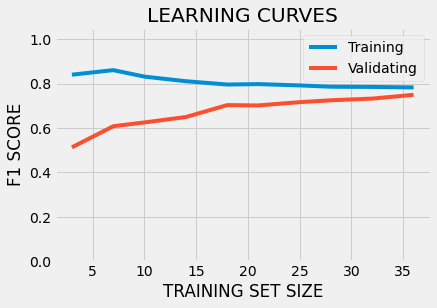

In [72]:
# check learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=final_ml_model, 
    X=X_final_train_modelling, y=y_final_train_modelling, 
    train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=seed),
    scoring="f1", n_jobs=-1, shuffle=True, random_state=seed
    )

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# plot learning curves
sns.lineplot(x = train_sizes, y = train_scores_mean, 
             estimator='mean', ci=95, n_boot=1000, label = "Training")
sns.lineplot(x = train_sizes, y = test_scores_mean, 
             estimator='mean', ci=95, n_boot=1000, label = "Validating")
# define plot details
plt.ylabel('F1 SCORE')
plt.xlabel('TRAINING SET SIZE')
plt.title('LEARNING CURVES')
plt.ylim(0, 1.05)
plt.legend();

## 14.2 - Validation performance

*Evaluate model performance on validation dataset*

In [73]:
# fit final model to data
final_ml_model.fit(X_final_train_modelling, y_final_train_modelling)

BernoulliNB()

## 14.1 - Test performance

*Evaluate model performance on test dataset*

In [74]:
# use the trained Robust Scaler to scale (transform) testing dataset
X_test_scaled = pd.DataFrame(data=rs.transform(X_test), columns=X_test.columns)

# inspect statistics
display("X_test", f'Shape: {X_test.shape}', X_test.describe(), 
        "X_test_scaled", f'Shape: {X_test_scaled.shape}', X_test_scaled.describe())

'X_test'

'Shape: (8, 69)'

,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,perct_child_parents_words,child_num_unique_words,perct_child_parents_unique_words,child_num_tokens,perct_child_parents_tokens,child_utterances,perct_child_parents_utterances,pos_percent_co,pos_percent_.,pos_percent_nan,pos_percent_n,pos_percent_v,pos_percent_!,pos_percent_pro:sub,pos_percent_adv,pos_percent_neg,pos_percent_qn,pos_percent_?,pos_percent_prep,pos_percent_mod,pos_percent_pro:per,pos_percent_pro:dem,pos_percent_adj,pos_percent_pro:rel,pos_percent_det:art,pos_percent_pro:int,pos_percent_aux,pos_percent_cop,pos_percent_+...,pos_percent_inf,pos_percent_conj,pos_percent_coord,pos_percent_+!?,pos_percent_post,pos_percent_pro:indef,pos_percent_part,pos_percent_det:poss,pos_percent_pro:obj,pos_percent_cm,pos_percent_det:num,pos_percent_adv:tem,pos_percent_+/.,pos_percent_det:dem,pos_percent_pro:exist,pos_percent_comp,pos_percent_n:prop,pos_percent_mid#n,pos_percent_on,pos_percent_re#v,pos_percent_n:gerund,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
count,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000
mean,3.703,0.676,3.025,0.702,0.414,1.463,50.250,0.628,313.000,0.409,87.125,0.446,328.125,0.402,87.000,0.560,0.099,0.194,0.102,0.115,0.067,0.022,0.031,0.027,0.009,0.014,0.015,0.022,0.011,0.031,0.014,0.018,0.003,0.029,0.008,0.012,0.022,0.002,0.008,0.005,0.010,0.001,0.002,0.005,0.013,0.013,0.003,0.012,0.034,0.001,0.002,0.005,0.001,0.001,0.010,0.000,0.003,0.000,0.000,0.000,0.001,0.000,0.000,0.001,0.000,0.001,0.001,0.000,0.001
std,2.037,0.286,1.706,0.280,0.097,0.501,25.999,0.285,179.682,0.281,51.148,0.243,191.240,0.279,26.667,0.197,0.068,0.073,0.109,0.054,0.038,0.026,0.023,0.024,0.011,0.012,0.015,0.022,0.012,0.021,0.013,0.016,0.005,0.021,0.006,0.009,0.021,0.003,0.009,0.008,0.013,0.002,0.002,0.004,0.011,0.019,0.005,0.011,0.075,0.002,0.003,0.008,0.003,0.003,0.012,0.000,0.006,0.000,0.000,0.001,0.001,0.000,0.000,0.003,0.000,0.003,0.001,0.000,0.003
min,1.581,0.361,1.359,0.396,0.321,0.834,18.000,0.243,115.000,0.144,22.000,0.165,115.000,0.136,44.000,0.329,0.029,0.113,0.011,0.023,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.007,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.396,0.415,1.743,0.491,0.350,1.222,20.000,0.323,141.000,0.195,36.750,0.253,142.250,0.190,75.500,0.359,0.045,0.141,0.026,0.087,0.050,0.003,0.010,0.007,0.000,0.003,0.001,0.000,0.000,0.016,0.004,0.008,0.000,0.012,0.005,0.005,0.009,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.003,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,3.362,0.674,2.867,0.689,0.377,1.327,63.000,0.752,318.500,0.350,93.000,0.438,346.000,0.340,80.000,0.600,0.085,0.172,0.051,0.119,0.071,0.012,0.041,0.027,0.003,0.012,0.012,0.023,0.010,0.029,0.014,0.016,0.000,0.028,0.007,0.012,0.017,0.000,0.007,0.002,0.007,0.000,0.000,0.006,0.013,0.004,0.002,0.012,0.000,0.000,0.001,0.000,0.000,0.000,0.006,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,4.396,0.825,3.491,0.782,0.466,1.651,70.250,0.852,461.000,0.546,133.750,0.611,485.000,0.548,101.750,0.702,0.135,0.231,0.155,0.141,0.093,0.031,0.047,0.045,0.017,0.027,0.028,0.032,0.0

'X_test_scaled'

'Shape: (8, 69)'

,child_mlu,percent_child_parents_mlu,child_mluw,percent_child_parents_mluw,child_ttr,percent_child_parents_ttr,child_ipsyn,percent_child_parents_ipsyn,child_num_words,perct_child_parents_words,child_num_unique_words,perct_child_parents_unique_words,child_num_tokens,perct_child_parents_tokens,child_utterances,perct_child_parents_utterances,pos_percent_co,pos_percent_.,pos_percent_nan,pos_percent_n,pos_percent_v,pos_percent_!,pos_percent_pro:sub,pos_percent_adv,pos_percent_neg,pos_percent_qn,pos_percent_?,pos_percent_prep,pos_percent_mod,pos_percent_pro:per,pos_percent_pro:dem,pos_percent_adj,pos_percent_pro:rel,pos_percent_det:art,pos_percent_pro:int,pos_percent_aux,pos_percent_cop,pos_percent_+...,pos_percent_inf,pos_percent_conj,pos_percent_coord,pos_percent_+!?,pos_percent_post,pos_percent_pro:indef,pos_percent_part,pos_percent_det:poss,pos_percent_pro:obj,pos_percent_cm,pos_percent_det:num,pos_percent_adv:tem,pos_percent_+/.,pos_percent_det:dem,pos_percent_pro:exist,pos_percent_comp,pos_percent_n:prop,pos_percent_mid#n,pos_percent_on,pos_percent_re#v,pos_percent_n:gerund,pos_percent_sub#n,pos_percent_n:pt,pos_percent_pro:refl,pos_percent_un#part,pos_percent_L2,pos_percent_chi,pos_percent_pro:poss,pos_percent_n:let,pos_percent_bab,pos_percent_sing
count,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000,8.000
mean,0.386,0.537,0.325,0.481,-0.340,-0.101,0.019,0.011,0.416,0.705,0.237,0.342,0.427,0.718,0.064,0.169,0.192,0.102,0.045,0.440,0.099,0.313,-0.154,-0.183,0.561,0.953,0.399,0.302,0.094,0.271,0.351,0.409,0.003,0.035,0.610,0.220,0.570,0.888,-0.003,0.924,0.614,0.001,0.748,0.106,0.349,0.805,-0.336,0.572,4.077,0.486,0.002,0.454,0.001,0.001,0.070,0.000,0.003,0.000,0.000,0.000,0.001,0.000,0.000,0.001,0.000,0.001,0.001,0.000,0.001
std,0.925,0.907,0.942,0.791,0.808,0.570,0.642,0.607,0.804,1.071,0.649,0.779,0.819,1.110,0.679,0.578,1.065,0.939,0.586,0.818,0.500,1.028,0.521,1.004,1.151,1.190,0.763,0.972,0.556,0.839,0.755,0.804,0.005,0.632,0.711,0.545,0.890,1.539,0.473,1.374,0.973,0.002,1.035,0.434,0.494,1.392,0.334,0.935,9.534,0.716,0.003,1.730,0.003,0.003,0.496,0.000,0.006,0.000,0.000,0.001,0.001,0.000,0.000,0.003,0.000,0.003,0.001,0.000,0.003
min,-0.578,-0.458,-0.595,-0.385,-1.120,-0.817,-0.778,-0.807,-0.470,-0.305,-0.590,-0.556,-0.486,-0.340,-1.032,-0.510,-0.898,-0.947,-0.448,-0.949,-0.685,-0.557,-0.854,-1.330,-0.352,-0.367,-0.370,-0.672,-0.438,-0.658,-0.499,-0.499,0.000,-0.847,-0.344,-0.445,-0.381,0.000,-0.434,0.000,-0.096,0.000,0.000,-0.531,-0.222,-0.178,-0.589,-0.393,-0.290,0.000,0.000,-0.581,0.000,0.000,-0.354,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-0.208,-0.288,-0.383,-0.116,-0.873,-0.375,-0.728,-0.637,-0.353,-0.111,-0.403,-0.275,-0.369,-0.127,-0.229,-0.424,-0.651,-0.583,-0.365,0.026,-0.116,-0.424,-0.624,-1.058,-0.352,-0.062,-0.302,-0.672,-0.438,-0.308,-0.239,-0.090,0.000,-0.467,0.305,-0.150,0.002,0.000,-0.434,0.000,-0.096,0.000,0.000,-0.126,-0.070,-0.062,-0.589,-0.393,-0.290,0.000,0.000,-0.581,0.000,0.000,-0.354,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.231,0.533,0.237,0.443,-0.649,-0.256,0.333,0.275,0.441,0.479,0.311,0.317,0.503,0.473,-0.115,0.285,-0.026,-0.183,-0.229,0.506,0.152,-0.088,0.058,-0.224,-0.051,0.746,0.242,0.364,0.040,0.203,0.360,0.300,0.000,0.008,0.596,0.234,0.337,0.000,-0.052,0.356,0.427,0.000,0.000,0.193,0.370,0.122,-0.435,0.637,-0.290,0.000,0.001,-0.581,0.000,0.000,-0.079,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.700,1.010,0.582,0.706,0.087,0.112,0.512,0.489,1.078,1.227,0.829,0.872,1.099,1.298,0.439,0.586,0.761,0.58

In [75]:
# filter features according to model training
X_test_scaled = X_test_scaled[f_selected_rf]
X_test_scaled

,perct_child_parents_utterances,percent_child_parents_ipsyn,child_num_words,child_ttr,pos_percent_det:art,pos_percent_?,percent_child_parents_ttr,child_utterances
0,-0.475,-0.627,-0.470,-0.170,-0.581,-0.370,-0.099,-1.032
1,0.978,0.550,1.405,-1.077,0.767,-0.280,-0.817,-0.217
2,0.482,0.623,0.917,-1.120,0.842,1.210,-0.299,0.344
3,0.087,-0.807,-0.421,-0.805,0.089,1.528,-0.311,-0.268
4,0.627,0.383,1.239,-0.762,-0.073,0.016,-0.568,1.185
5,0.573,0.468,1.025,-0.535,0.509,0.468,-0.212,0.726
6,-0.510,-0.670,-0.331,0.894,-0.847,-0.370,0.747,-0.064
7,-0.406,0.167,-0.036,0.857,-0.429,0.986,0.753,-0.166


In [76]:
# inspect y values
display("y_test", y_test.shape, y_test)

'y_test'

(8,)

0    1
1    0
2    0
3    0
4    0
5    1
6    1
7    0
Name: ASD, dtype: int64

In [77]:
# check model
final_ml_model

BernoulliNB()

In [78]:
# get classification metrics
get_class_metrics(
    y_true=y_test.values, 
    y_pred=final_ml_model.predict(X_test_scaled), 
    y_pred_proba=final_ml_model.predict_proba(X_test_scaled)[:, 1]
    )

# M = CAT BOOST
# S = RandomOverSampling 	
# F = Random Forest
# {'accuracy': 0.75,
#  'precision': 0.6666666666666666,
#  'recall': 0.6666666666666666,
#  'f1': 0.6666666666666666,
#  'roc_auc': 0.6666666666666666,
#  'precision_recall_auc': 0.7767857142857143,
#  'log_loss': 0.6181944795062282}

# M = RANDOM FORREST
# S = RandomOverSampling
# F = OR
# {'accuracy': 0.75,
#  'precision': 0.6666666666666666,
#  'recall': 0.6666666666666666,
#  'f1': 0.6666666666666666,
#  'roc_auc': 0.7333333333333333,
#  'precision_recall_auc': 0.7936507936507937,
#  'log_loss': 0.5744867759955802}

{'accuracy': 0.75,
 'precision': 0.6666666666666666,
 'recall': 0.6666666666666666,
 'f1': 0.6666666666666666,
 'roc_auc': 0.7666666666666666,
 'precision_recall_auc': 0.8047619047619048,
 'log_loss': 0.6898481466213191}

## 14.4 - Confusion Matrix

*Display confusion matrix*

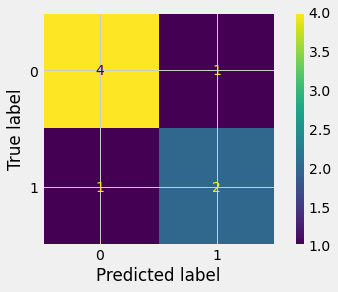

In [79]:
# calculate confusion matrix 
cm = confusion_matrix(
    y_true=y_test.values, 
    y_pred=final_ml_model.predict(X_test_scaled), 
    labels=final_ml_model.classes_
    )

# prepare confusion matrix display
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=final_ml_model.classes_)

# plot 
disp.plot();

# 15 - Model diagnostics

## 15.1 - Feature importance

*Check the importance of features for model prediciton*


9 features selected...



['pos_percent_det:num',
 'pos_percent_re#v',
 'pos_percent_pro:refl',
 'pos_percent_coord',
 'pos_percent_adv:tem',
 'pos_percent_mod',
 'child_utterances',
 'pos_percent_pro:rel',
 'perct_child_parents_utterances']

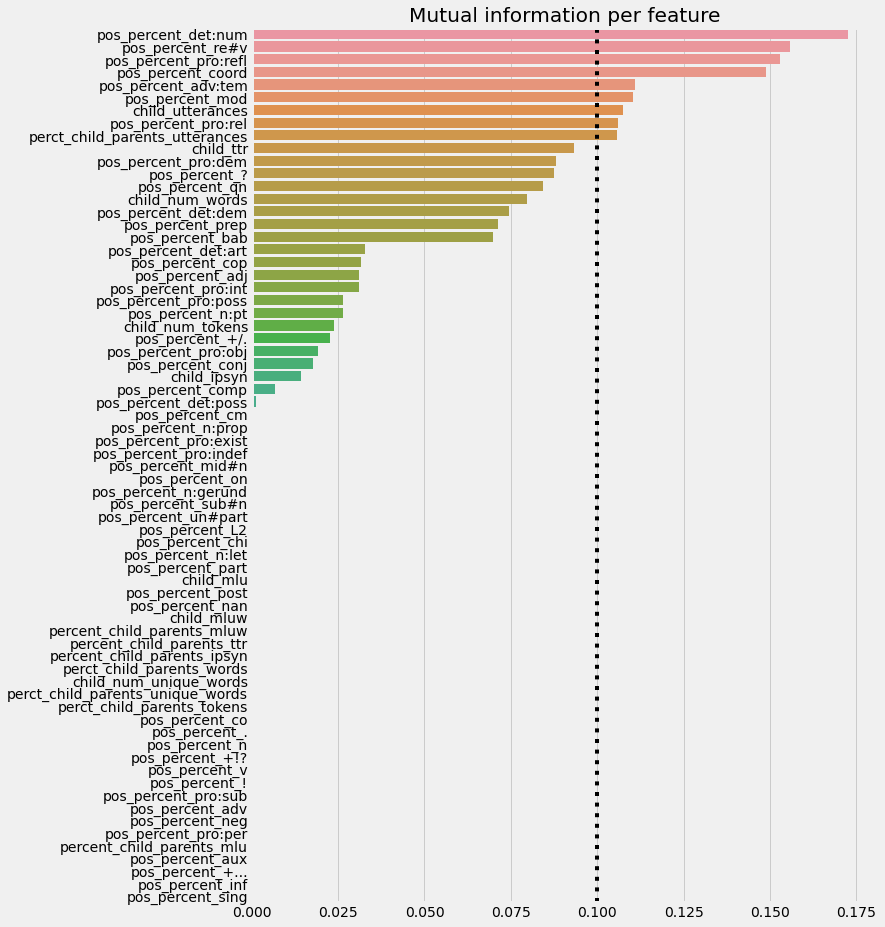

In [80]:
# calculate mutual information between features and target
mutual_info = mutual_info_classif(X_train_scaled, y_train, random_state=seed)

# create a series from mutual information
mutual_info_series = pd.Series(mutual_info)
# add column labels as index
mutual_info_series.index=X_train.columns
# sort in descending order
mutual_info_series = mutual_info_series.sort_values(ascending=False)

# get features whose mutual_info_series > 0.1
# 0.1 was chosen more or less using the elbow method approach
f_selected_mi = mutual_info_series[mutual_info_series > 0.1].index.tolist()
# print info
print(
    f'\n{len(f_selected_mi)} features selected...\n',
)
display(f_selected_mi)

# define figure size
fig = plt.figure(figsize=(10, 15))

# plot
sns.barplot(y=mutual_info_series.index, x=mutual_info_series)
# define details
plt.title("Mutual information per feature", loc="center")
plt.axvline(0.1, linestyle=":", color="black")
plt.show()

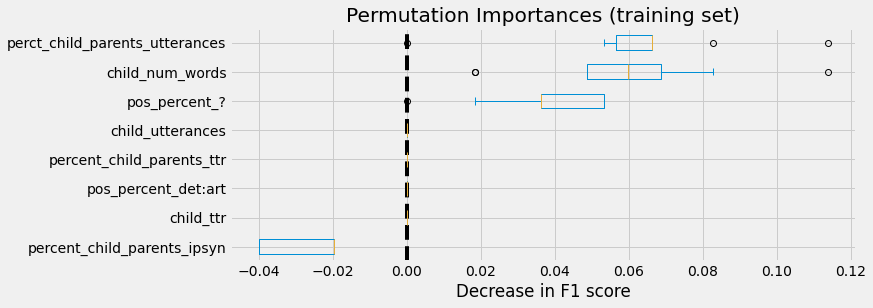

In [81]:
# calculate feature importance with feature permutation method
result = permutation_importance(
    estimator=final_ml_model, 
    X=X_final_train_modelling,
    y=y_final_train_modelling, 
    scoring='f1', 
    n_repeats=10, 
    n_jobs=-1, 
    random_state=seed, 
)   

# get index to sort features by mean of importance
sorted_importances_idx = result.importances_mean.argsort()
# create a dataframe with importances
df_perm_importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_final_train_modelling.columns[sorted_importances_idx],
)

# boxplot importances
df_perm_importances.plot.box(
    vert=False, # draw horizontal boxes
    whis=1.5, # whiskers
    figsize=(10, 4)
    )
# plot details
plt.title("Permutation Importances (training set)")
plt.axvline(x=0, color="k", linestyle="--")
plt.xlabel("Decrease in F1 score");

## 15.2 - Bias analysis

*Check for bias on model predictions*

In [82]:
# TO-DO

## 15.3 - Uncertainty analysis

*Check for uncertainty on model predictions*

In [83]:
# TO-DO

## 15.4 - SHAP values

*Inspect shap values for model prediction*

### 15.4.1 - Shap on **training** dataset

Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
Attribute `intercept_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).


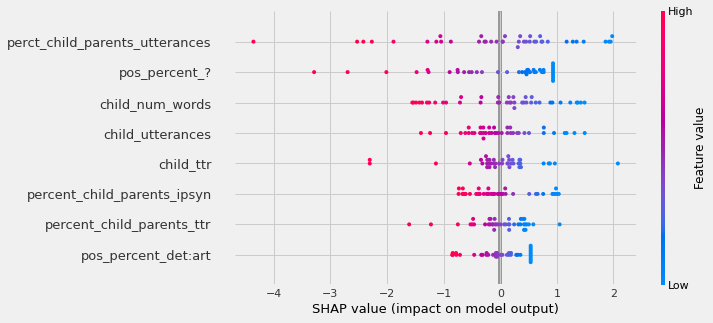

In [84]:
# compute SHAP values
explainer = shap.Explainer(final_ml_model, X_final_train_modelling)
shap_values = explainer(X_final_train_modelling)

# plot shap values for features
shap.plots.beeswarm(shap_values, order=shap_values.abs.mean(0), max_display=10)

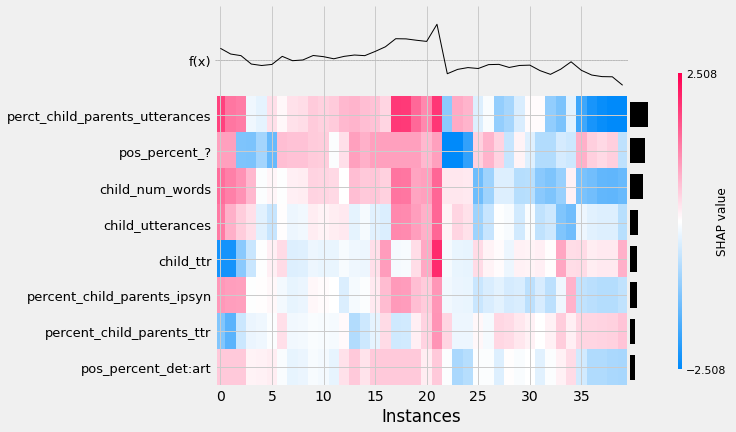

In [85]:
# plot heatmap
shap.plots.heatmap(shap_values[:1000], max_display=10, feature_values=shap.Explanation.abs.mean(0))

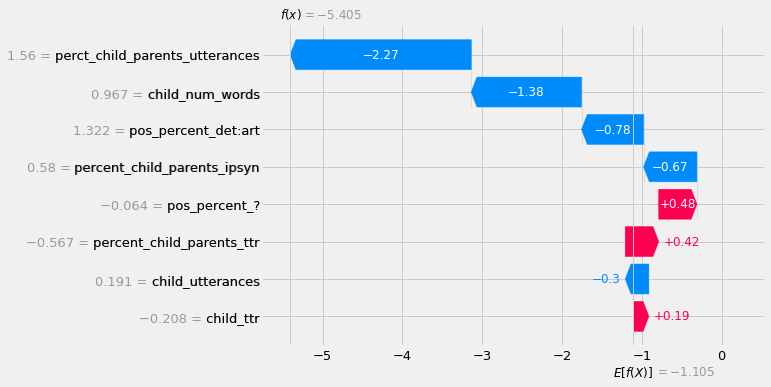

In [86]:
# plot shap values for a given prediction
shap.plots.waterfall(shap_values[37], max_display=10)

### 15.4.1 - Shap on **test** dataset

Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
Attribute `intercept_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).


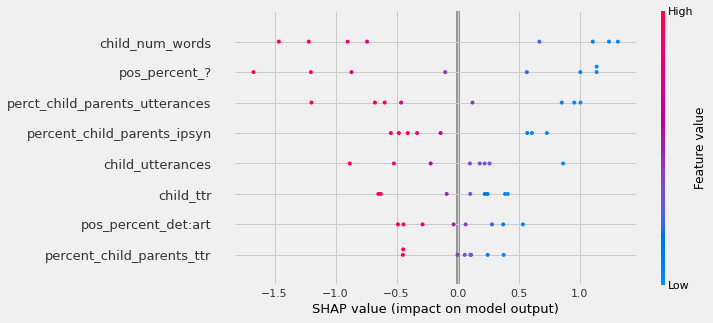

In [87]:
# compute SHAP values
explainer = shap.Explainer(final_ml_model, X_test_scaled)
shap_values = explainer(X_test_scaled)

# plot shap values for features
shap.plots.beeswarm(shap_values, order=shap_values.abs.mean(0), max_display=10)

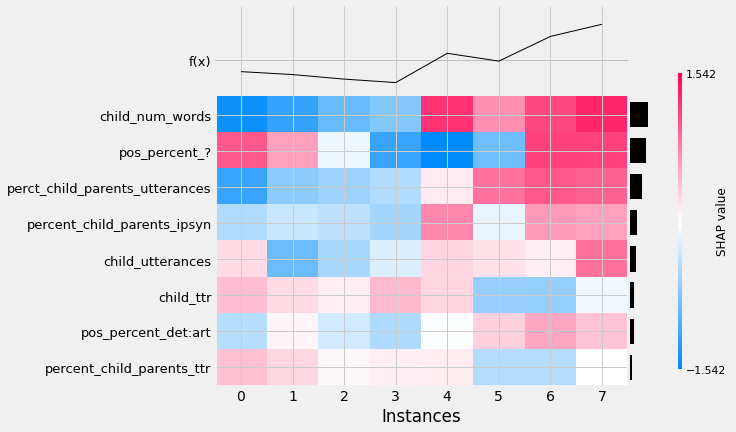

In [88]:
# plot heatmap
shap.plots.heatmap(shap_values[:1000], max_display=10, feature_values=shap.Explanation.abs.mean(0))

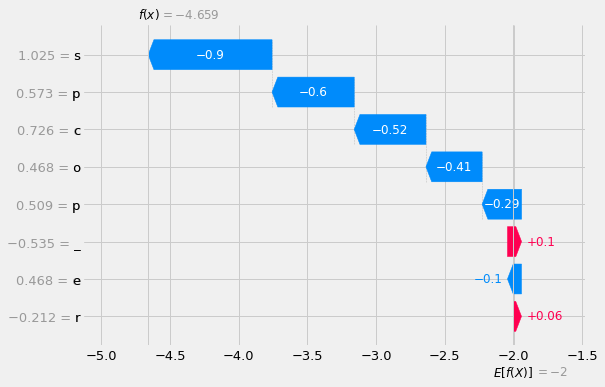

In [89]:
# plot shap values for a given prediction
shap.plots.waterfall(shap_values[5], max_display=10)

# 16 - Prepare model for production

In [90]:
# TO-DO

In [92]:
# print python dependencies
!pip freeze

absl-py==1.4.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.4
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.2.0
audioread==3.0.0
autograd==1.5
Babel==2.11.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==6.0.0
blis==0.7.9
bokeh==2.3.3
Boruta==0.3
branca==0.6.0
bs4==0.0.1
CacheControl==0.12.11
cachetools==5.3.0
catalogue==2.0.8
catboost==1.1.1
certifi==2022.12.7
cffi==1.15.1
cftime==1.6.2
chardet==4.0.0
charset-normalizer==3.0.1
click==7.1.2
clikit==0.6.2
cloudpickle==2.2.1
cmake==3.22.6
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.4
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.3
cycler==0.11.0
cymem==2.0.7
Cython==0.29.33
daft==0.0.4
dask==2022.2.1
datascience==0